<h1>Online Retail Insights and Forecasting</h1>

### Dataset Source: [Link](https://doi.org/10.24432/C5CG6D)

In [275]:
#importing all libraries
from datetime import timedelta
from keras.models import Sequential
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
# Suppress warnings:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [11]:
df = pd.read_excel('online_retail_II.xlsx')
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

### 1. DATASET EXPLORATION AND CLEANING

In [14]:
# shape of this dataset
print("Total Rows:", df.shape[0])
print("Total Columns:", df.shape[1])

Total Rows: 525461
Total Columns: 8


In [12]:
#getting all column names
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [19]:
#Statistical summary
df.describe()

Quantity          Price    Customer ID
count  525461.000000  525461.000000  417534.000000
mean       10.337667       4.688834   15360.645478
std       107.424110     146.126914    1680.811316
min     -9600.000000  -53594.360000   12346.000000
25%         1.000000       1.250000   13983.000000
50%         3.000000       2.100000   15311.000000
75%        10.000000       4.210000   16799.000000
max     19152.000000   25111.090000   18287.000000

In [20]:
#Checking if there are any null values or not
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [31]:
description_nulls = df.query("Description.isnull()", engine="python")
description_nulls.head()

Invoice StockCode Description  Quantity         InvoiceDate  Price  \
470   489521     21646         NaN       -50 2009-12-01 11:44:00    0.0   
3114  489655     20683         NaN       -44 2009-12-01 17:26:00    0.0   
3161  489659     21350         NaN       230 2009-12-01 17:39:00    0.0   
3731  489781     84292         NaN        17 2009-12-02 11:45:00    0.0   
4296  489806     18010         NaN      -770 2009-12-02 12:42:00    0.0   

      Customer ID         Country  
470           NaN  United Kingdom  
3114          NaN  United Kingdom  
3161          NaN  United Kingdom  
3731          NaN  United Kingdom  
4296          NaN  United Kingdom

In [33]:
customer_id_nulls = df.query('`Customer ID`.isnull()', engine='python')
customer_id_nulls.head()

Invoice StockCode                Description  Quantity  \
263  489464     21733               85123a mixed       -96   
283  489463     71477                      short      -240   
284  489467    85123A                21733 mixed      -192   
470  489521     21646                        NaN       -50   
577  489525    85226C  BLUE PULL BACK RACING CAR         1   

            InvoiceDate  Price  Customer ID         Country  
263 2009-12-01 10:52:00   0.00          NaN  United Kingdom  
283 2009-12-01 10:52:00   0.00          NaN  United Kingdom  
284 2009-12-01 10:53:00   0.00          NaN  United Kingdom  
470 2009-12-01 11:44:00   0.00          NaN  United Kingdom  
577 2009-12-01 11:49:00   0.55          NaN  United Kingdom

- Before making decision on whether to drop or to replace null values, we will try to analyze it more deeply and see what we can do with it.

In [35]:
# Distribution of product descriptions
description_counts = df["Description"].value_counts(normalize=True)

# Proportion of rows with missing 'Description' relative to the entire dataset
missing_description_proportion = df["Description"].isnull().mean()

description_counts.head(), missing_description_proportion

(WHITE HANGING HEART T-LIGHT HOLDER    0.006792
 REGENCY CAKESTAND 3 TIER              0.004233
 STRAWBERRY CERAMIC TRINKET BOX        0.003527
 PACK OF 72 RETRO SPOT CAKE CASES      0.002806
 ASSORTED COLOUR BIRD ORNAMENT         0.002788
 Name: Description, dtype: float64,
 0.005572249891048051)

In [36]:
# Analyzing rows with missing 'Customer ID'
missing_customer_id_rows = df[df["Customer ID"].isnull()]

# Summarizing
numeric_summary_missing_id = missing_customer_id_rows[["Quantity", "Price"]].describe()

# Distribution of 'Country' for rows with missing 'Customer ID'
country_distribution_missing_id = missing_customer_id_rows["Country"].value_counts(
    normalize=True
)

# Proportion of rows with missing 'Customer ID' relative to the entire dataset
missing_customer_id_proportion = df["Customer ID"].isnull().mean()

numeric_summary_missing_id, country_distribution_missing_id.head(), missing_customer_id_proportion

(            Quantity          Price
 count  107927.000000  107927.000000
 mean        0.971045       7.788750
 std       128.207415     290.474071
 min     -9600.000000  -53594.360000
 25%         1.000000       1.660000
 50%         1.000000       3.360000
 75%         2.000000       5.910000
 max     10200.000000   25111.090000,
 United Kingdom          0.986120
 EIRE                    0.008895
 United Arab Emirates    0.001056
 Portugal                0.000713
 Hong Kong               0.000704
 Name: Country, dtype: float64,
 0.20539488182757618)

- The most frequent product descriptions constitute around 0.5% to 0.7% of the entire dataset.
- The proportion of rows with missing Description is approximately 0.56% of the dataset.
- If we fill missing descriptions with "Unknown", this category would be among the top descriptions, but not overwhelmingly so.
- If we drop the rows with missing descriptions, we're only losing about 0.56% of our data, which might not significantly impact most analyses.
- The average Quantity for rows with missing Customer ID is approximately 0.97 with a high standard deviation, indicating variability.
- The average Price for rows with missing Customer ID is around 7.79, but there's a wide range of values with a high standard deviation.
- Interestingly, there are negative prices in rows with missing Customer ID, which might be related to refunds or other transactional adjustments.
- About 98.6% of the rows with missing Customer ID are from the 'United Kingdom'.
- The rest are distributed among various countries, with 'EIRE' being the second most common.
- Rows with missing Customer ID constitute approximately 20.54% of the dataset.

Based on all the points, it looks like dropping Description null values and keeping Customer ID's is our best option here, so lets go ahead with it.

In [37]:
#Lets drop Description null values
df = df.dropna(subset=['Description'])
df.shape

(522533, 8)

In [39]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [40]:
#Let's convert 'InvoiceDate' column to datetime data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

- As we decided not to drop our Customer ID null values, we have to make sure it doesn't make any noise in our futher analysis, we decide to fill null values with -1.

In [41]:
# Filling missing values in 'Customer ID' column with -1
df["Customer ID"].fillna(-1, inplace=True)

# Convert 'Customer ID' column to integer data type
df["Customer ID"] = df["Customer ID"].astype(int)

# Verify the changes
customer_id_dtype = df["Customer ID"].dtype
customer_id_unique_values = df["Customer ID"].nunique()
customer_id_min_value = df["Customer ID"].min()

customer_id_dtype, customer_id_unique_values, customer_id_min_value

(dtype('int32'), 4384, -1)

- All missing values have been filled with the placeholder -1.
- The column has been converted to an integer data type (int64).
- There are now 4,384 unique customer IDs, including the placeholder -1.

In [42]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom

- It was noticed that code starting with the letter 'c', it indicates a cancellation in Invoice, let's see what other character we have and all

In [44]:
c = df[df['Invoice'].str.startswith('C', na=False)]
c.head()

Invoice StockCode                    Description  Quantity  \
178  C489449     22087       PAPER BUNTING WHITE LACE       -12   
179  C489449    85206A   CREAM FELT EASTER EGG BASKET        -6   
180  C489449     21895  POTTING SHED SOW 'N' GROW SET        -4   
181  C489449     21896             POTTING SHED TWINE        -6   
182  C489449     22083     PAPER CHAIN KIT RETRO SPOT       -12   

            InvoiceDate  Price  Customer ID    Country  
178 2009-12-01 10:33:00   2.95        16321  Australia  
179 2009-12-01 10:33:00   1.65        16321  Australia  
180 2009-12-01 10:33:00   4.25        16321  Australia  
181 2009-12-01 10:33:00   2.10        16321  Australia  
182 2009-12-01 10:33:00   2.95        16321  Australia

In [46]:
# Get the frequency of all first characters in the 'Invoice' column
invoice_first_char_frequency = df['Invoice'].str[0].value_counts()
invoice_first_char_frequency

C    10206
A        3
Name: Invoice, dtype: int64

- Invoice Starting with 'C': Appears 10,206 times. These represent cancellations.
- Invoice Starting with 'A': Appears 3 times. Let's take these as adjustments for bad debt.

In [48]:
# Check the structure of the Customer ID entries
valid_customer_ids = df["Customer ID"].isin(range(10000, 100000)).sum()
placeholder_count = (df["Customer ID"] == -1).sum()

valid_customer_ids, placeholder_count

(417534, 104999)

- There are 417,534 entries that are 5-digit numbers, aligning with the expected format for customer IDs.
- Additionally, there are 104,999 entries with the placeholder value -1, which we used to represent missing customer IDs.

In [49]:
# Summarizing everything we did till now

# 1. Completeness: Check for missing or placeholder values
missing_values = df.isnull().sum()
placeholder_values = (df == -1).sum()

# 2. Consistency: We've mostly ensured consistency in earlier steps, but we'll recheck data types for consistency.
data_types = df.dtypes

# 3. Uniqueness: Check for duplicate rows
duplicate_rows = df.duplicated().sum()

# 4. Validity: Based on earlier steps, most columns have been validated. We'll specifically check ranges for numeric columns.
quantity_range = (df["Quantity"].min(), df["Quantity"].max())
price_range = (df["Price"].min(), df["Price"].max())

# 5. Relevance: All columns seem relevant based on earlier discussions.
missing_values, placeholder_values, data_types, duplicate_rows, quantity_range, price_range

(Invoice        0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 Price          0
 Customer ID    0
 Country        0
 dtype: int64,
 Invoice             0
 StockCode           0
 Description         0
 Quantity         4590
 InvoiceDate         0
 Price               0
 Customer ID    104999
 Country             0
 dtype: int64,
 Invoice                object
 StockCode              object
 Description            object
 Quantity                int64
 InvoiceDate    datetime64[ns]
 Price                 float64
 Customer ID             int32
 Country                object
 dtype: object,
 6865,
 (-9360, 19152),
 (-53594.36, 25111.09))

- We will dive more into our dataset and see what else we can clean.
- Cleaning is the crucial part and should be handeled very carefully.

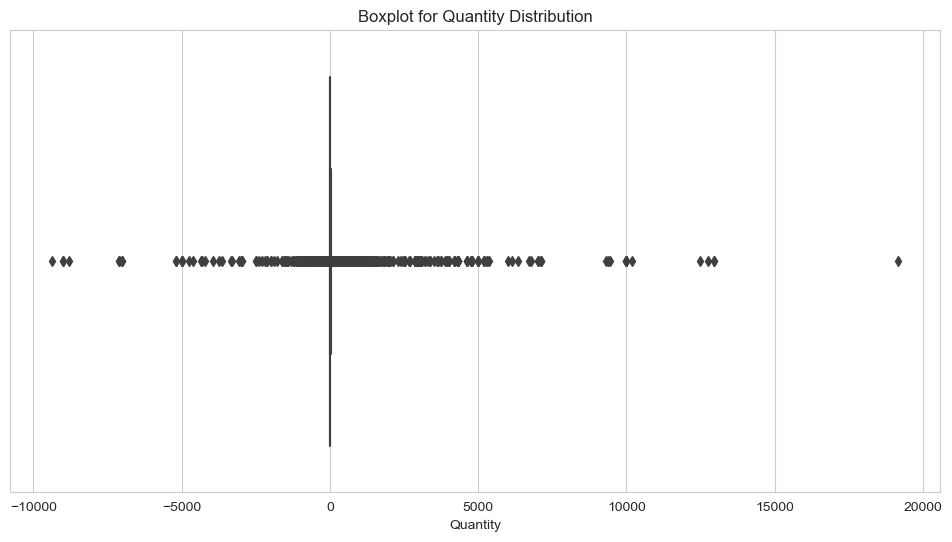

count    522533.000000
mean         10.514312
std          97.905985
min       -9360.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: Quantity, dtype: float64

In [51]:
# Set up the plotting style
sns.set_style("whitegrid")

# Plotting boxplot for Quantity
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot for Quantity Distribution')
plt.show()

# Compute summary statistics for Quantity
quantity_summary = df['Quantity'].describe()

quantity_summary

- The median (50th percentile) quantity is 3.
- The interquartile range (IQR) – the range between the 25th percentile (1) and the 75th percentile (10) – is 9. Most of the data falls within this range.
- There are significant outliers on both the lower and upper ends.
- The minimum quantity is -9,360, which indicates cancellations or returns.
- The maximum quantity is 19,152, which is unusually high.
- The boxplot displays numerous data points outside the "whiskers", indicating potential outliers.

In [52]:
# Extracting top outlier entries for Quantity
upper_outliers_threshold = quantity_summary["75%"] + 1.5 * (
        quantity_summary["75%"] - quantity_summary["25%"]
)
upper_outliers = df[df["Quantity"] > upper_outliers_threshold]

# Displaying a sample of the top outlier entries
upper_outliers.sample(10)

Invoice StockCode                         Description  Quantity  \
100825  498910     21869             POTTING SHED COFFEE MUG       216   
172939  505744     20713                      JUMBO BAG OWLS       200   
484360  534738     22952     60 CAKE CASES VINTAGE CHRISTMAS        24   
339718  522513     21977  PACK OF 60 PINK PAISLEY CAKE CASES       360   
156311  504217     22534       MAGIC DRAWING SLATE SPACEBOY         48   
187841  507235     22525        CHILDRENS GARDEN GLOVES PINK        24   
129605  501709     84991         60 TEATIME FAIRY CAKE CASES        24   
92580   498114     20719              WOODLAND CHARLOTTE BAG       100   
118822  500721     85200                       BUNNY EGG BOX        24   
114213  500320     21232      STRAWBERRY CERAMIC TRINKET BOX        24   

               InvoiceDate  Price  Customer ID         Country  
100825 2010-02-23 15:17:00   1.06        14091  United Kingdom  
172939 2010-04-26 07:15:00   1.65        15769  United Kingdom  
484360 2010-11-23 19:24:00   0.55        12377     Switzerland  
339718 2010-09-15 11:35:00   0.42        14156            EIRE  
156311 2010-04-12 12:50:00   0.42        14844  United Kingdom  
187841 2010-05-07 09:04:00   1.06        14298  United Kingdom  
129605 2010-03-19 10:02:00   0.55        15615  United Kingdom  
92580  2010-02-16 14:32:00   0.72        15311  United Kingdom  
118822 2010-03-09 15:22:00   1.25        17059  United Kingdom  
114213 2010-03-07 12:03:00   1.25        16271  United Kingdom

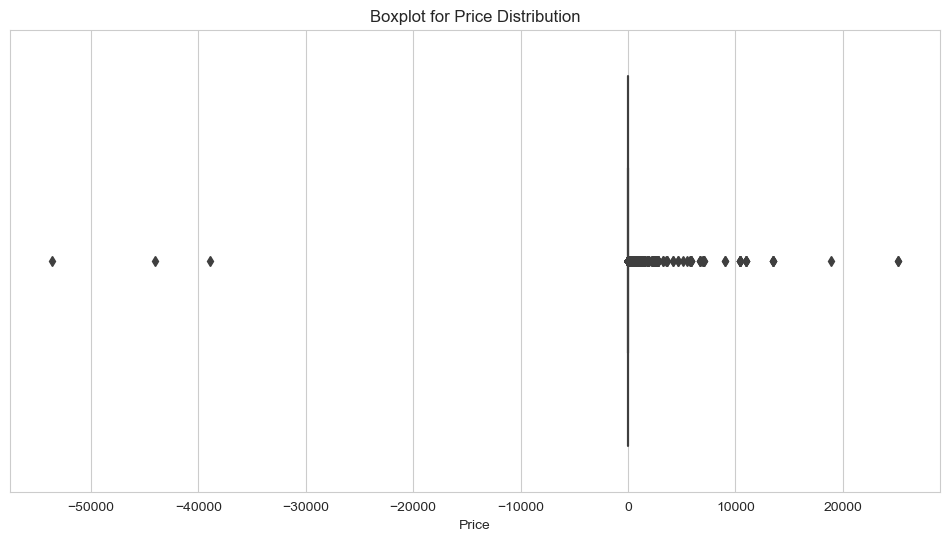

count    522533.000000
mean          4.715108
std         146.535329
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: Price, dtype: float64

In [53]:
# Plotting boxplot for Price
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Price'])
plt.title('Boxplot for Price Distribution')
plt.show()

# Compute summary statistics for Price
price_summary = df['Price'].describe()

price_summary

- The median (50th percentile) price is 2.10.
- The interquartile range (IQR) – the range between the 25th percentile (1.25) and the 75th percentile (4.21) – is 2.96. This shows that most of the product prices fall within this range.
- There are significant outliers on both the lower and upper ends.
- The minimum price is a negative value at -53,594.36, which likely corresponds to adjustments or cancellations.
- The maximum price is 25,111.09, which is exceptionally high and might represent high-value products or data errors.
- The boxplot displays numerous data points outside the "whiskers", indicating potential outliers.

In [54]:
# Extracting top outlier entries for Price
upper_price_threshold = price_summary["75%"] + 1.5 * (
        price_summary["75%"] - price_summary["25%"]
)
upper_price_outliers = df[df["Price"] > upper_price_threshold]

# Displaying a sample of the top outlier entries for Price
upper_price_outliers.sample(10)

Invoice StockCode                          Description  Quantity  \
199867  508592     21623         VINTAGE UNION JACK MEMOBOARD         2   
279284  516588    72760B    VINTAGE CREAM 3 BASKET CAKE STAND         2   
313321  519887    72760B    VINTAGE CREAM 3 BASKET CAKE STAND         2   
117120  500503     22485        SET OF 2 WOODEN MARKET CRATES         1   
132561  501922     21359             RELAX LARGE WOOD LETTERS         1   
110525  499980     21523  DOOR MAT FANCY FONT HOME SWEET HOME         1   
44926   493393     21299          EDWARDIAN TOILET ROLL UNIT          4   
235187  512126     22487       WHITE WOOD GARDEN PLANT LADDER         1   
170217  505522     21217           RED SPOTTY ROUND CAKE TINS         1   
38145   492540     37500          TEA TIME TEAPOT IN GIFT BOX         1   

               InvoiceDate  Price  Customer ID         Country  
199867 2010-05-17 12:05:00   9.95        13488  United Kingdom  
279284 2010-07-21 13:38:00   9.95        17663  United Kingdom  
313321 2010-08-22 12:03:00   9.95        18260  United Kingdom  
117120 2010-03-08 13:38:00  12.75        15916  United Kingdom  
132561 2010-03-22 10:26:00  15.95        13151  United Kingdom  
110525 2010-03-03 15:28:00  13.57           -1  United Kingdom  
44926  2009-12-23 13:00:00  12.75        12539           Spain  
235187 2010-06-13 16:10:00   9.95        16558  United Kingdom  
170217 2010-04-22 15:58:00   9.95        14911            EIRE  
38145  2009-12-17 13:36:00   9.95        15005  United Kingdom

- The high prices are associated with various products, such as the RED RETROSPOT CAKE STAND, DOORMAT NEIGHBOURHOOD WITCH, and WHITE WOOD GARDEN PLANT LADDER.
- The prices appear legitimate and don't seem to be errors.
- Some of the items, like the TRIANGULAR POUFFE VINTAGE, have prices that are understandably higher due to the nature of the product.
- Some high-priced items have a Customer ID of -1, indicating they were purchased by unidentified customers.
- Based on this, the high prices in the outliers seem valid, therefore we choose not to mess with them.

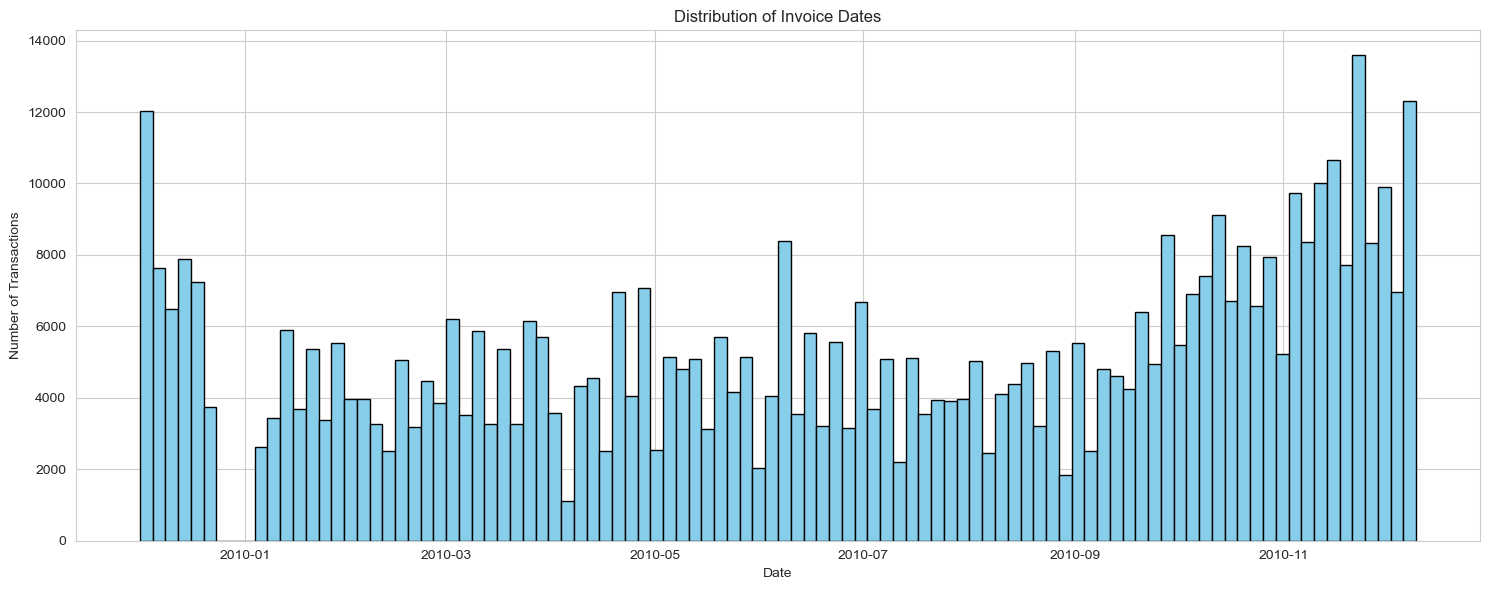

In [55]:
# Plotting the distribution of InvoiceDates
plt.figure(figsize=(15, 6))
df["InvoiceDate"].hist(bins=100, color="skyblue", edgecolor="black")
plt.title("Distribution of Invoice Dates")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

- The InvoiceDate column has a consistent range of dates without any major gaps.
- The distribution of dates has peaks and troughs, suggesting regular seasonal patterns.
- There is no evidence of missing data based on the date.
- The InvoiceDate column is suitable for time-based analysis.

With this:
- We've verified that quantities, both negative (returns/cancellations) and positive (sales), seem valid.
- Prices, including high outliers, have been reviewed and seem legitimate.
- The temporal distribution of transactions is consistent.

In [56]:
df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom

In [64]:
countries = df['Country'].unique()
countries[:10]

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark'], dtype=object)

In [65]:
# Saving our cleaned dataset
df.to_csv('cleaned.csv')

##### Overall Summmary:
- Handled and filled missing values in Description and Customer ID.
- Checked and ensured data types are consistent with expectations.
- Addressed special cases like cancellations, bad debt adjustments, and bulk purchases.
- Validated the dataset against the provided additional information.
- Conducted outlier detection and validated high outliers for both Quantity and Price.
- Verified the temporal consistency of the InvoiceDate column.
- Price is considered to be in Sterling(£).

With this, we are done with cleaning.

### 2. BUSINESS METRICS

In [68]:
df = pd.read_csv("cleaned.csv", encoding="ISO-8859-1", parse_dates=["InvoiceDate"])
df.head()

Unnamed: 0 Invoice StockCode                          Description  \
0           0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS   
1           1  489434    79323P                   PINK CHERRY LIGHTS   
2           2  489434    79323W                  WHITE CHERRY LIGHTS   
3           3  489434     22041         RECORD FRAME 7" SINGLE SIZE    
4           4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX   

   Quantity         InvoiceDate  Price  Customer ID         Country  
0        12 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1        12 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2        12 2009-12-01 07:45:00   6.75        13085  United Kingdom  
3        48 2009-12-01 07:45:00   2.10        13085  United Kingdom  
4        24 2009-12-01 07:45:00   1.25        13085  United Kingdom

#### 2.1 Calculating Monthly Revenue

In [72]:
# Extract month-year from InvoiceDate and create a new column
df["Month-Year"] = df["InvoiceDate"].dt.to_period("M")

# Calculate monthly revenue
monthly_revenue = (
    df.groupby("Month-Year")
    .apply(lambda x: (x["Quantity"] * x["Price"]).sum())
    .reset_index(name="Revenue")
)
monthly_revenue

Month-Year      Revenue
0     2009-12   799847.110
1     2010-01   624032.892
2     2010-02   533091.426
3     2010-03   765848.761
4     2010-04   590580.432
5     2010-05   615322.830
6     2010-06   679786.610
7     2010-07   575236.360
8     2010-08   656776.340
9     2010-09   853650.431
10    2010-10  1045168.350
11    2010-11  1422654.642
12    2010-12   377488.450

- The data starts from December 2009 and goes up to December 2010.
- Revenue tends to fluctuate month by month, with notable peaks in October and November 2010.

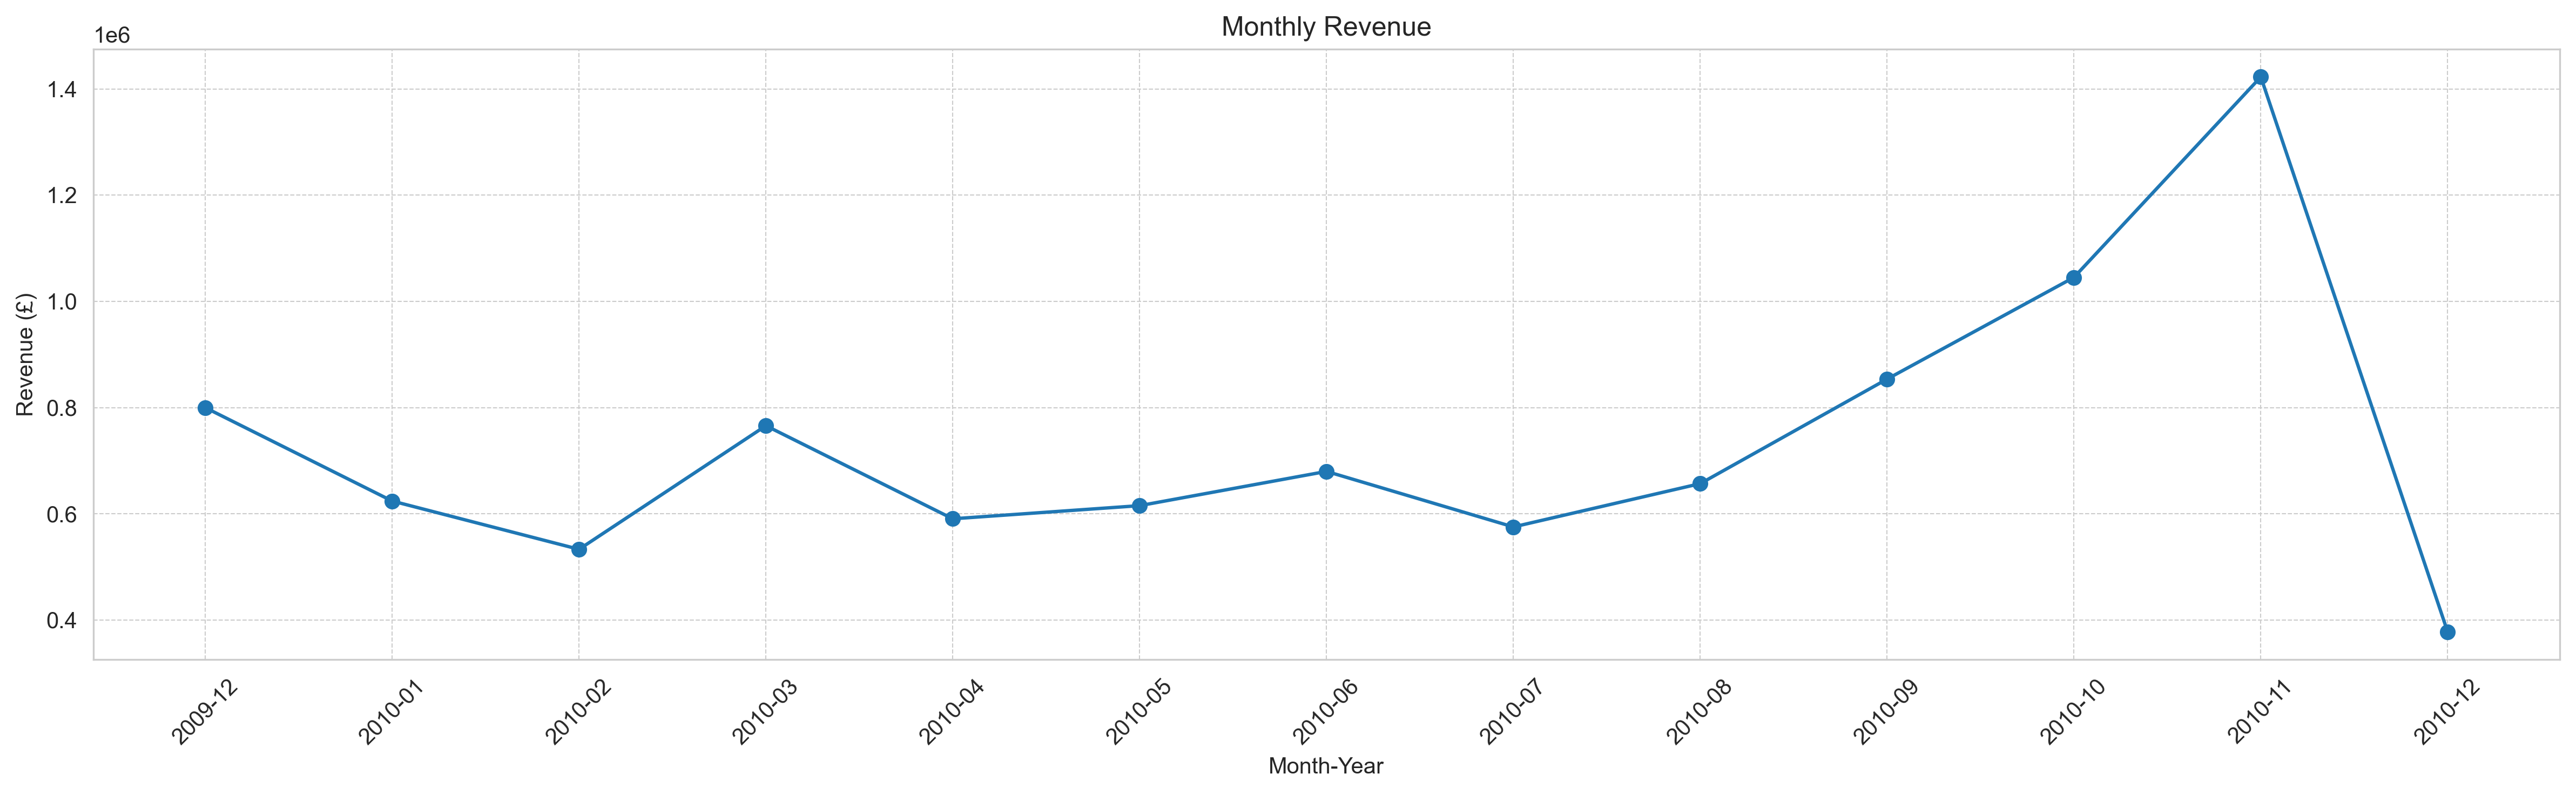

In [82]:
# Plotting using Matplotlib
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(
    monthly_revenue["Month-Year"], monthly_revenue["Revenue"], marker="o", linestyle="-"
)
plt.title("Monthly Revenue")
plt.xlabel("Month-Year")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

- The line chart displays the revenue for each month from December 2009 to December 2010.
- The graph clearly highlights the growth in revenue, with peaks in November and October 2010.

#### 2.2 Calculating Monthly Growth Rate

In [83]:
monthly_revenue["MonthlyGrowth"] = round(monthly_revenue["Revenue"].pct_change(), 2)
monthly_revenue.head()

Month-Year     Revenue  MonthlyGrowth
0    2009-12  799847.110            NaN
1    2010-01  624032.892          -0.22
2    2010-02  533091.426          -0.15
3    2010-03  765848.761           0.44
4    2010-04  590580.432          -0.23

- From December 2009 to January 2010, there's a 22% decrease in revenue. Similarly, from January 2010 to February 2010, there's a 15% decrease, and so on.

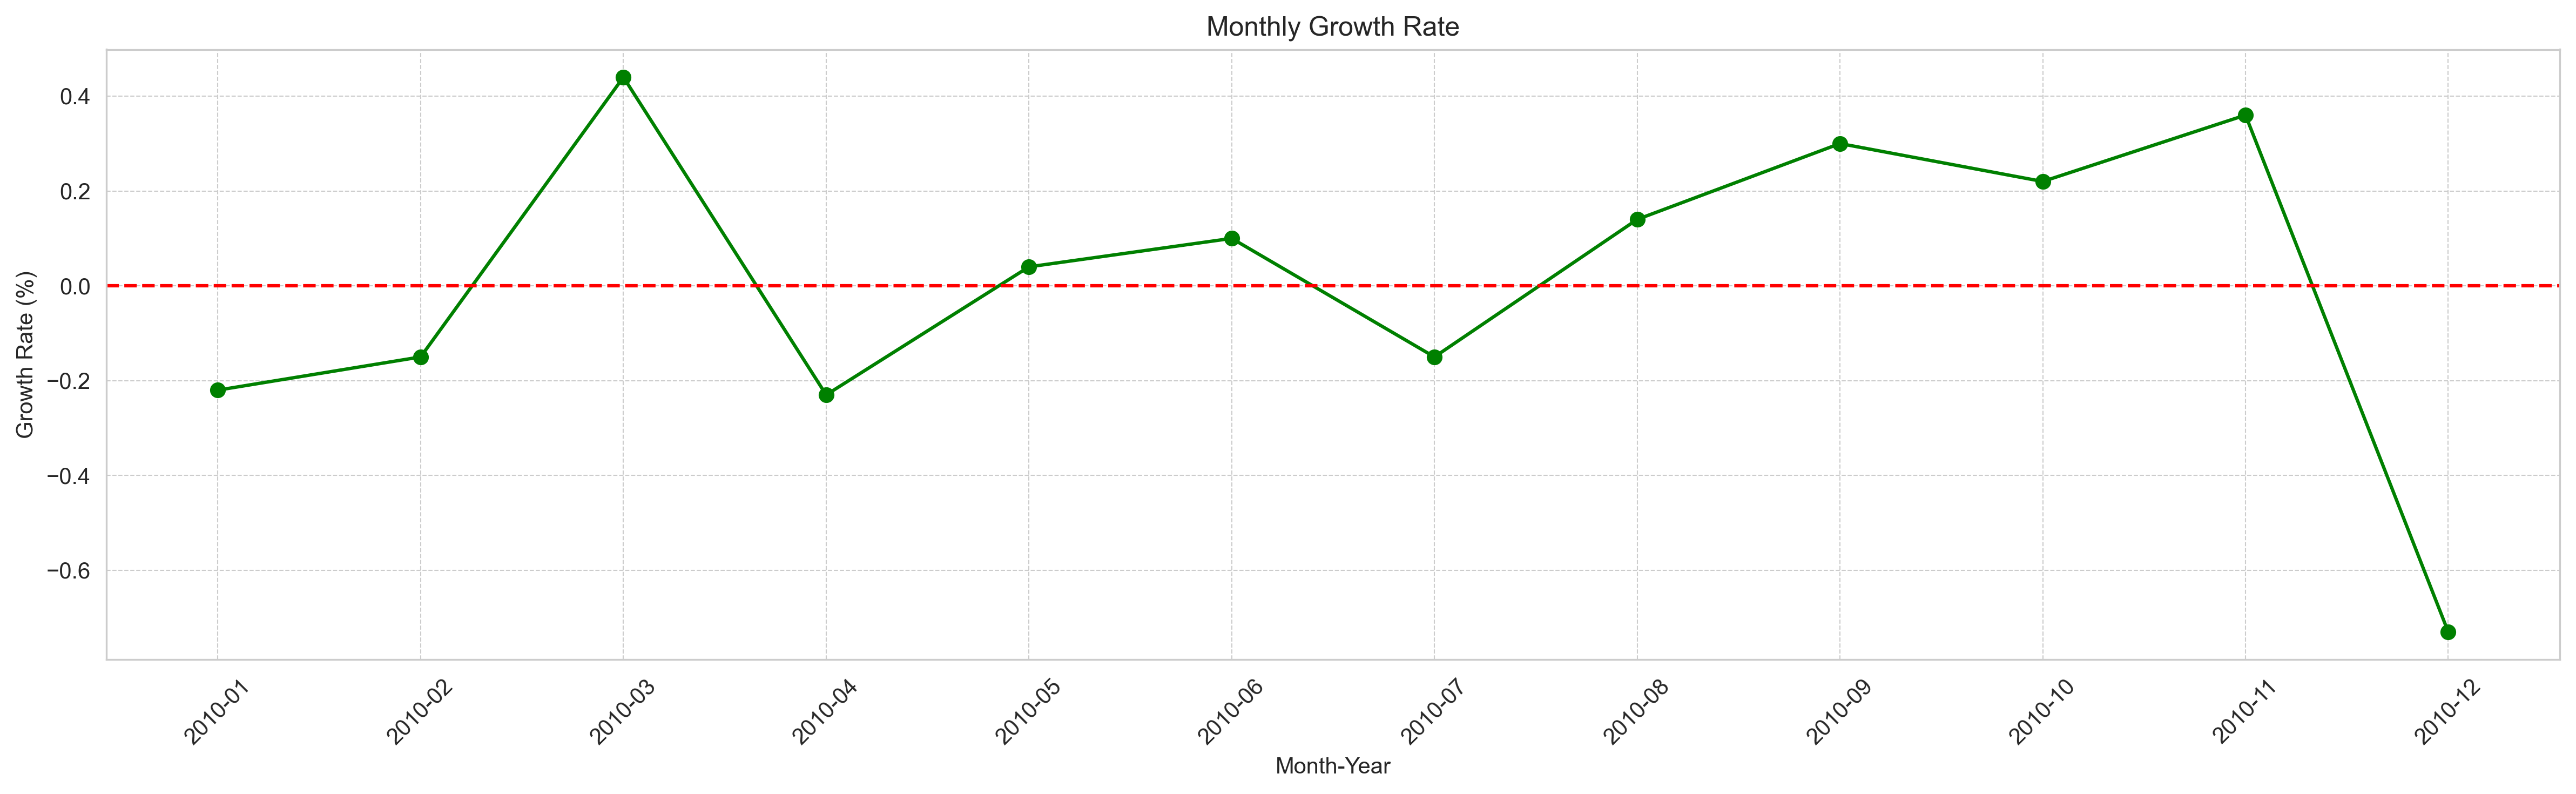

In [85]:
# Convert 'Month-Year' column to string type for plotting
monthly_revenue["Month-Year"] = monthly_revenue["Month-Year"].astype(str)

# Plotting Monthly Growth Rate
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(
    monthly_revenue["Month-Year"],
    monthly_revenue["MonthlyGrowth"],
    marker="o",
    linestyle="-",
    color="green",
)
plt.title("Monthly Growth Rate")
plt.xlabel("Month-Year")
plt.ylabel("Growth Rate (%)")
plt.axhline(y=0, color="red", linestyle="--")  # Line to denote the 0% mark
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

- The line chart shows the growth rate of sales for each month from December 2009 to December 2010.
- The red dashed line represents the 0% growth rate.
- There were sharp drops in growth rate in January, March, and May.
- There were significant positive growth rates in July, October, and November.

#### 2.3 Revenue By Country

In [89]:
revenue_by_country = (
    df.groupby("Country")
    .apply(lambda x: (x["Quantity"] * x["Price"]).sum())
    .sort_values(ascending=False)
    .astype(int)
)
revenue_by_country

Country
United Kingdom          8194777
EIRE                     352242
Netherlands              263863
Germany                  196290
France                   130769
Sweden                    51213
Denmark                   46972
Switzerland               43343
Spain                     37084
Australia                 30051
Portugal                  23769
Belgium                   22663
Channel Islands           21367
Greece                    14284
Italy                     13788
Austria                   13023
Cyprus                    11216
Japan                      8435
United Arab Emirates       8046
Finland                    7187
Unspecified                4937
Lithuania                  4892
USA                        4555
Norway                     4079
Singapore                  4037
Hong Kong                  3922
Poland                     3314
Israel                     3199
Thailand                   3070
Malta                      2686
RSA                        2366


- UK has the highest revenue, totaling £8,194,777.
- EIRE (Ireland), Netherlands, Germany, and France follow with substantial revenue figures.
- Some countries, such as Nigeria, show negative revenue. This could be due to returns, refunds, or other transaction adjustments that exceeded sales in those regions.

#### 2.4 Monthly Active Customers

In [90]:
monthly_active = df.groupby("Month-Year")["Customer ID"].nunique().reset_index()
monthly_active.columns = ["Month-Year", "Customers"]

monthly_active

Month-Year  Customers
0     2009-12       1046
1     2010-01        787
2     2010-02        808
3     2010-03       1112
4     2010-04        999
5     2010-05       1063
6     2010-06       1096
7     2010-07        989
8     2010-08        965
9     2010-09       1203
10    2010-10       1578
11    2010-11       1684
12    2010-12        623

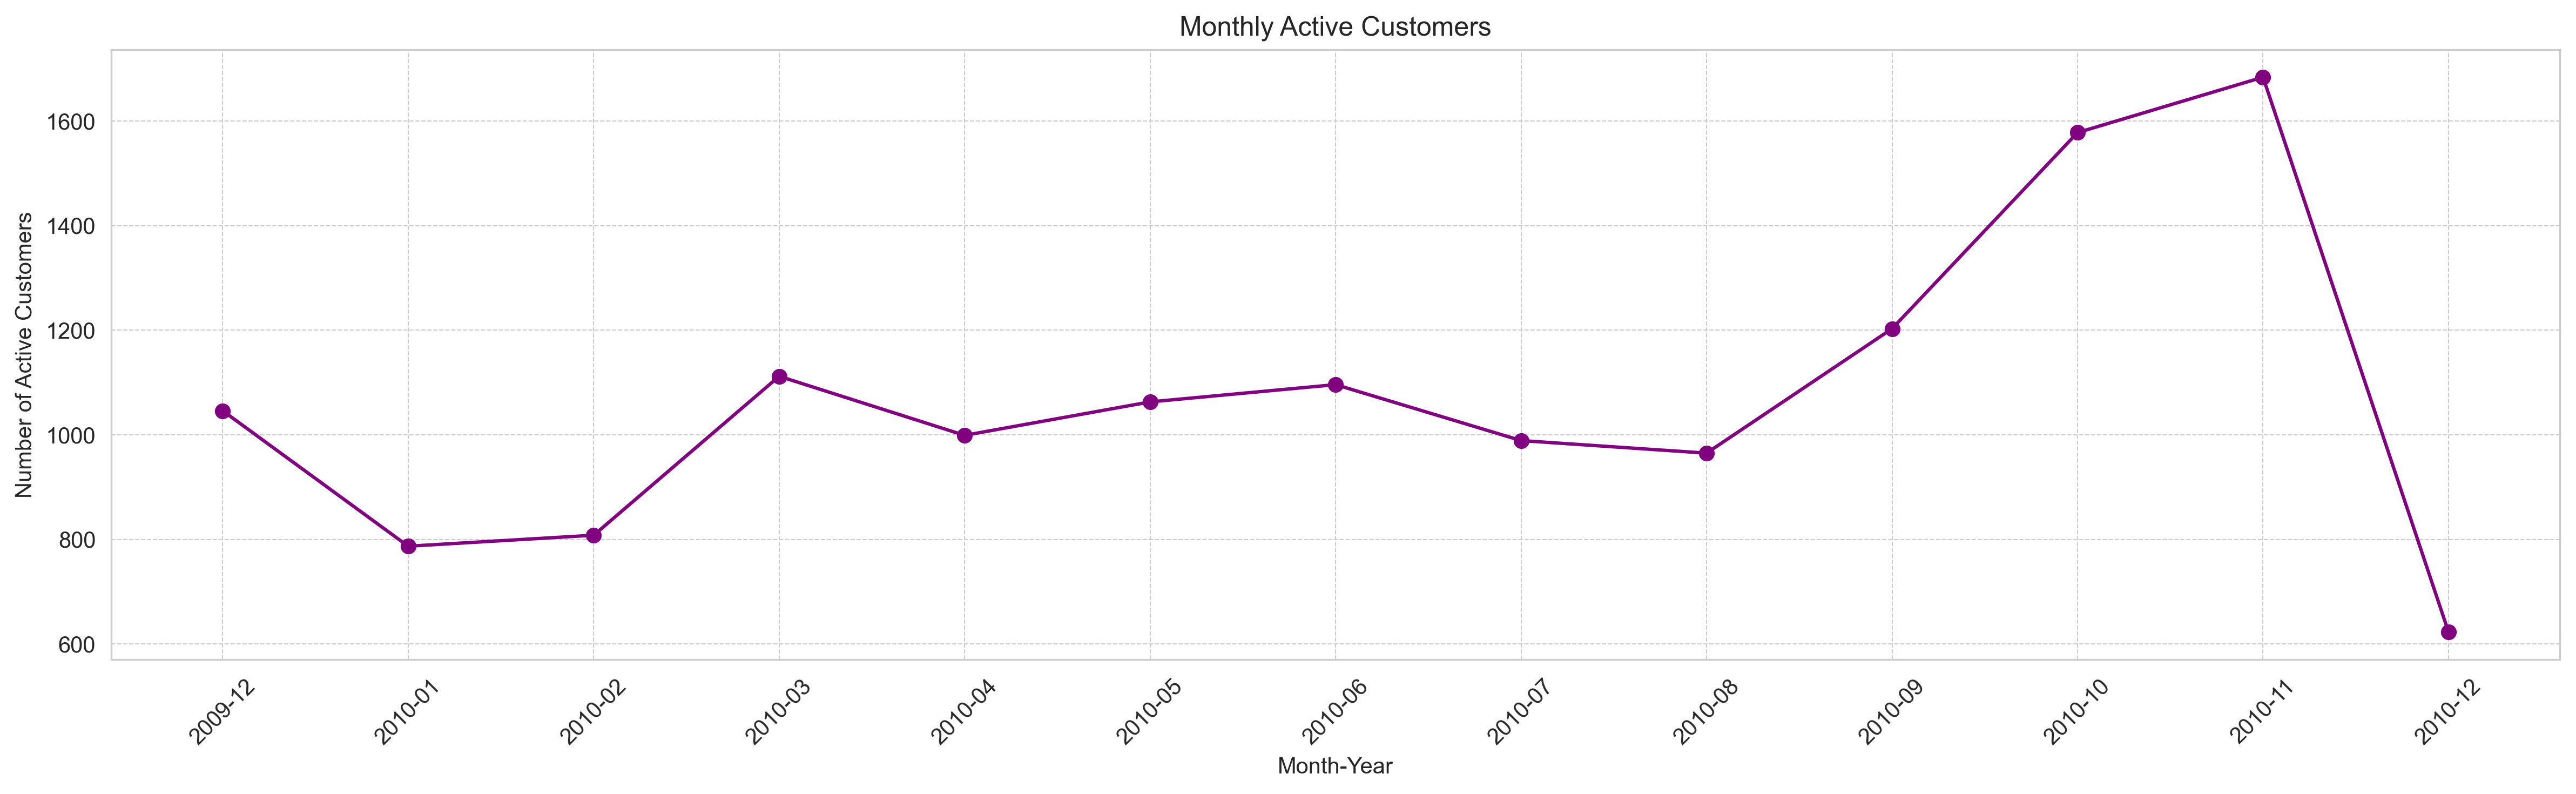

In [91]:
# Plotting Monthly Active Customers
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(
    monthly_active["Month-Year"],
    monthly_active["Customers"],
    marker="o",
    color="purple",
)
plt.title("Monthly Active Customers")
plt.xlabel("Month-Year")
plt.ylabel("Number of Active Customers")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

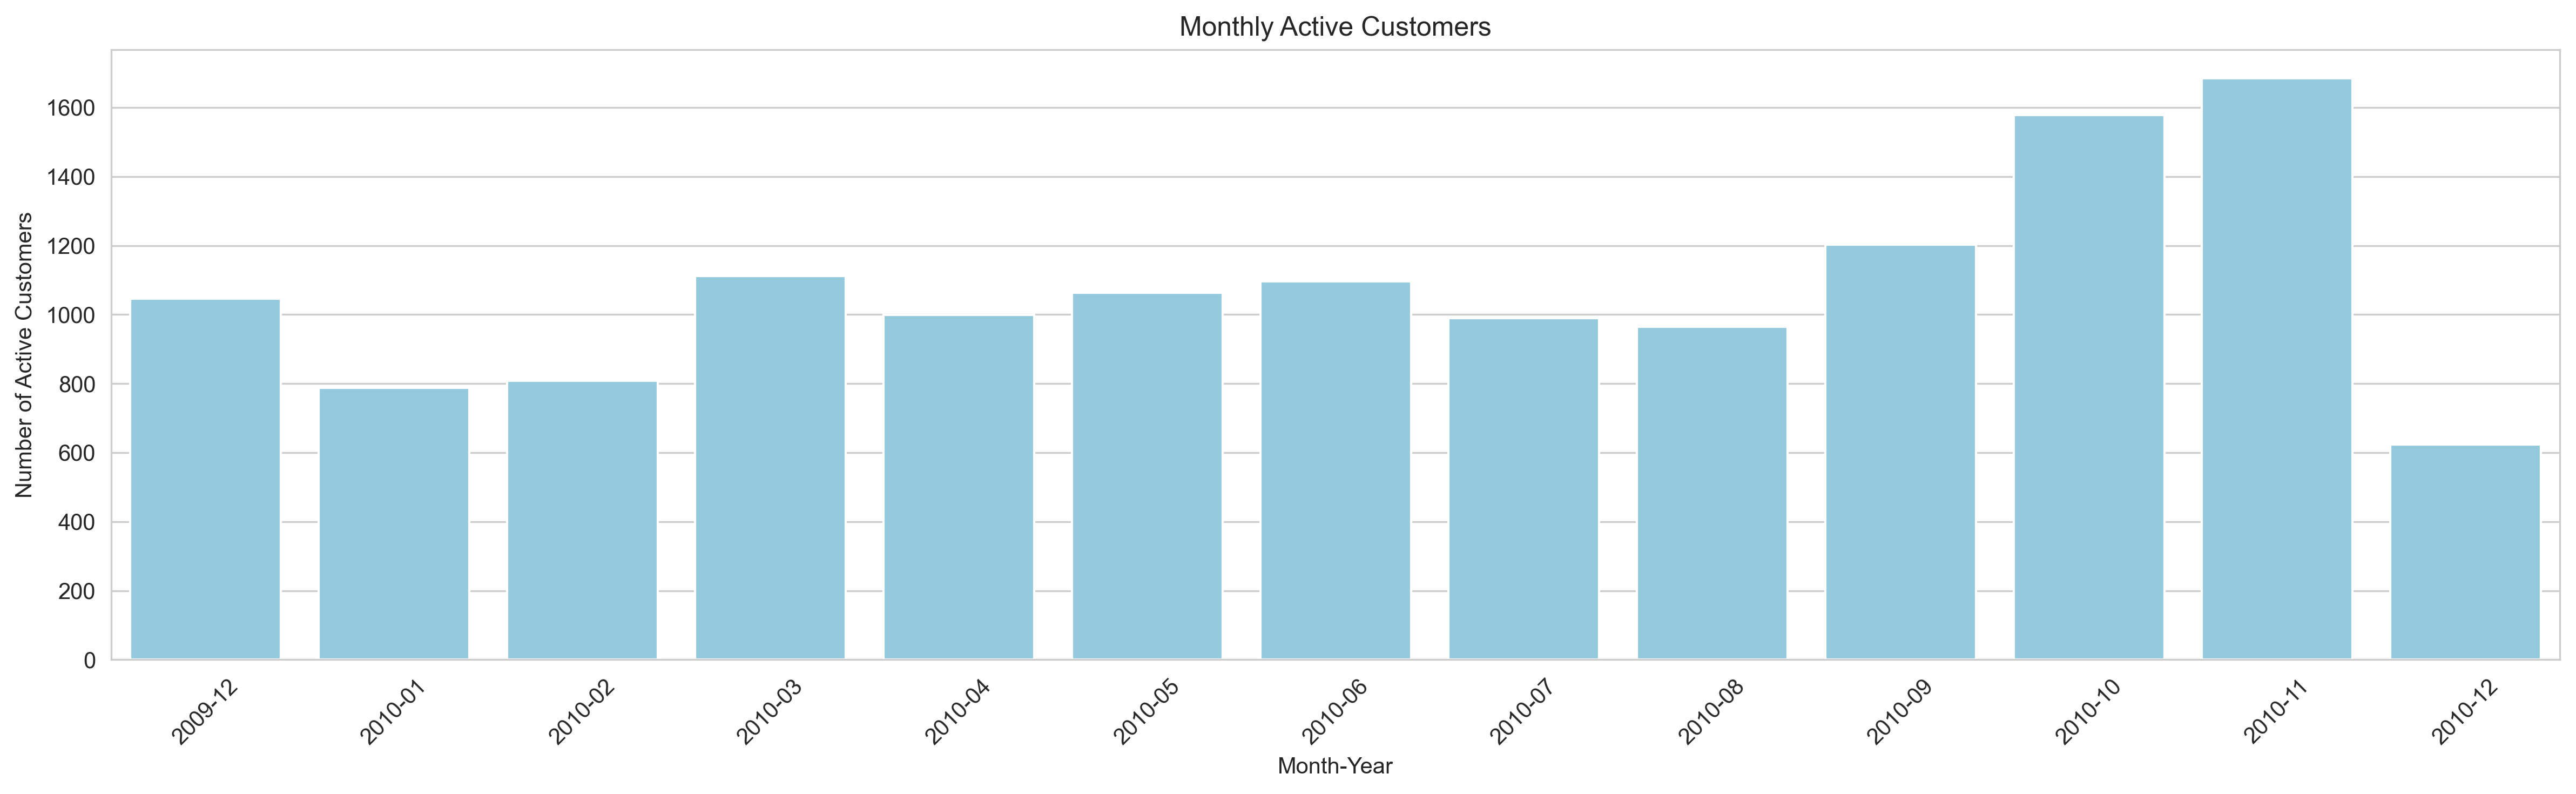

In [92]:
# Plotting Monthly Active Customers using a bar plot
plt.figure(figsize=(16, 5), dpi=300)
sns.barplot(
    x=monthly_active["Month-Year"], y=monthly_active["Customers"], color="skyblue"
)
plt.title("Monthly Active Customers")
plt.xlabel("Month-Year")
plt.ylabel("Number of Active Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The bar chart shows the number of active customers for each month from December 2009 to December 2010.
- The height of each bar represents the number of active customers for that month.
- There is an increase in the number of active customers over the year, with pronounced peaks in September and November 2010.

#### 2.5 Monthly Orders

In [94]:
monthly_orders_df = (
    df.groupby("Month-Year")["Invoice"].nunique().reset_index(name="Number of Orders")
)
monthly_orders_df

Month-Year  Number of Orders
0     2009-12              2102
1     2010-01              1411
2     2010-02              1459
3     2010-03              2115
4     2010-04              1782
5     2010-05              1942
6     2010-06              2041
7     2010-07              1932
8     2010-08              1718
9     2010-09              2240
10    2010-10              2808
11    2010-11              3357
12    2010-12               981

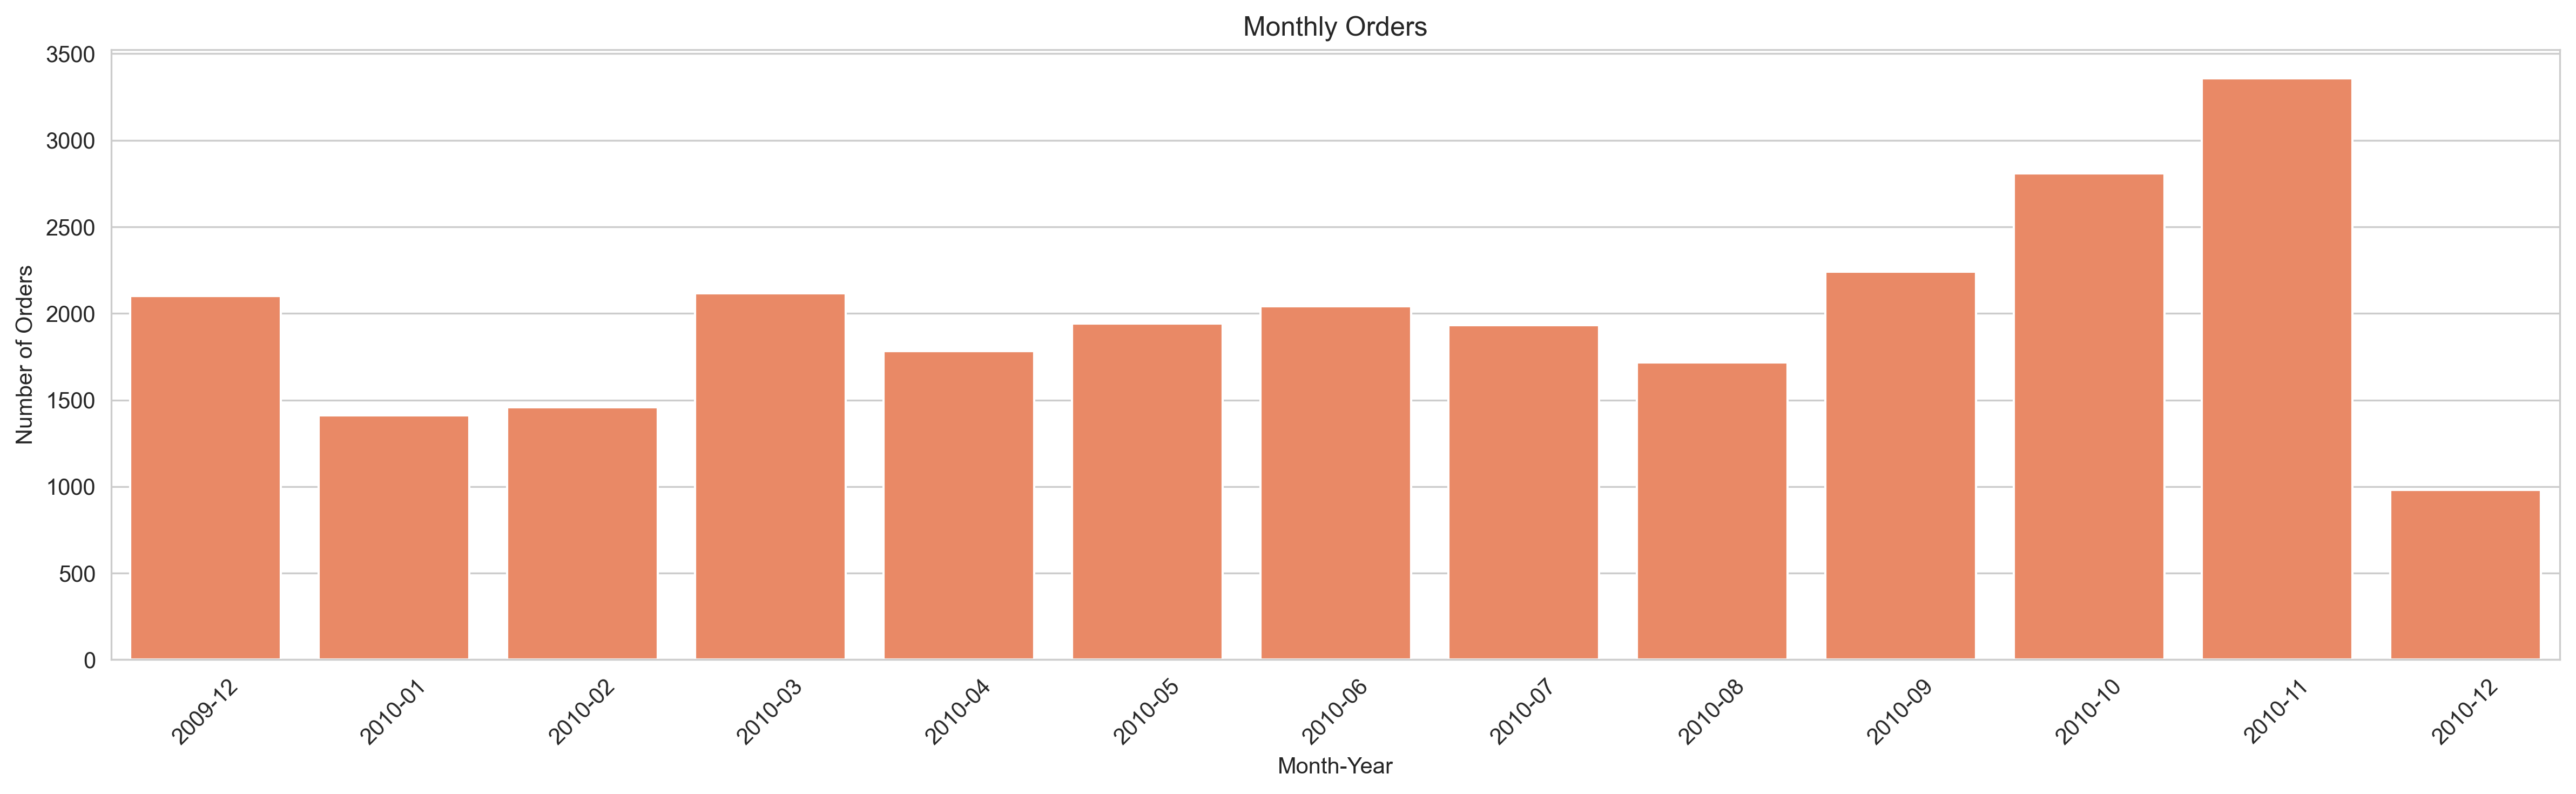

In [95]:
# Plotting Monthly Orders using the monthly_orders_df DataFrame
plt.figure(figsize=(16, 5), dpi=300)
sns.barplot(
    x=monthly_orders_df["Month-Year"],
    y=monthly_orders_df["Number of Orders"],
    color="coral",
)
plt.title("Monthly Orders")
plt.xlabel("Month-Year")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Looks like order volume generally increases over the year.
- Notable peaks in order count are observed in September and November 2010.
- The months with the highest order volume can indicate periods of heightened sales activity or successful marketing campaigns.

#### 2.6 Monthly Average Revenue Per Order

In [98]:
df["TotalRevenue"] = df["Quantity"] * df["Price"]
average_revenue = (
    df.groupby("Month-Year")
    .apply(lambda x: x["TotalRevenue"].sum() / x["Invoice"].nunique())
    .reset_index()
)
average_revenue.columns = ["Month-Year", "Average Revenue per Order"]
average_revenue

Month-Year  Average Revenue per Order
0     2009-12                 380.517179
1     2010-01                 442.262858
2     2010-02                 365.381375
3     2010-03                 362.103433
4     2010-04                 331.414384
5     2010-05                 316.850067
6     2010-06                 333.065463
7     2010-07                 297.741387
8     2010-08                 382.291234
9     2010-09                 381.093942
10    2010-10                 372.210951
11    2010-11                 423.787501
12    2010-12                 384.799643

- In December 2009 (2009-12), the average revenue per order was approximately £380.52.
- In November 2010 (2010-11), the average revenue per order was around £423.79.

In [102]:
# Let's see it in more interesting format
monthly_order_and_revenue = (
    df.groupby("Month-Year")
    .agg({"Invoice": "nunique", "TotalRevenue": "sum"})
    .reset_index()
)
monthly_order_and_revenue.columns = ["Month-Year", "Number of Orders", "Total Revenue"]
combined_data = pd.merge(monthly_order_and_revenue, average_revenue, on="Month-Year")
combined_data

Month-Year  Number of Orders  Total Revenue  Average Revenue per Order
0     2009-12              2102     799847.110                 380.517179
1     2010-01              1411     624032.892                 442.262858
2     2010-02              1459     533091.426                 365.381375
3     2010-03              2115     765848.761                 362.103433
4     2010-04              1782     590580.432                 331.414384
5     2010-05              1942     615322.830                 316.850067
6     2010-06              2041     679786.610                 333.065463
7     2010-07              1932     575236.360                 297.741387
8     2010-08              1718     656776.340                 382.291234
9     2010-09              2240     853650.431                 381.093942
10    2010-10              2808    1045168.350                 372.210951
11    2010-11              3357    1422654.642                 423.787501
12    2010-12               981     377488.450                 384.799643

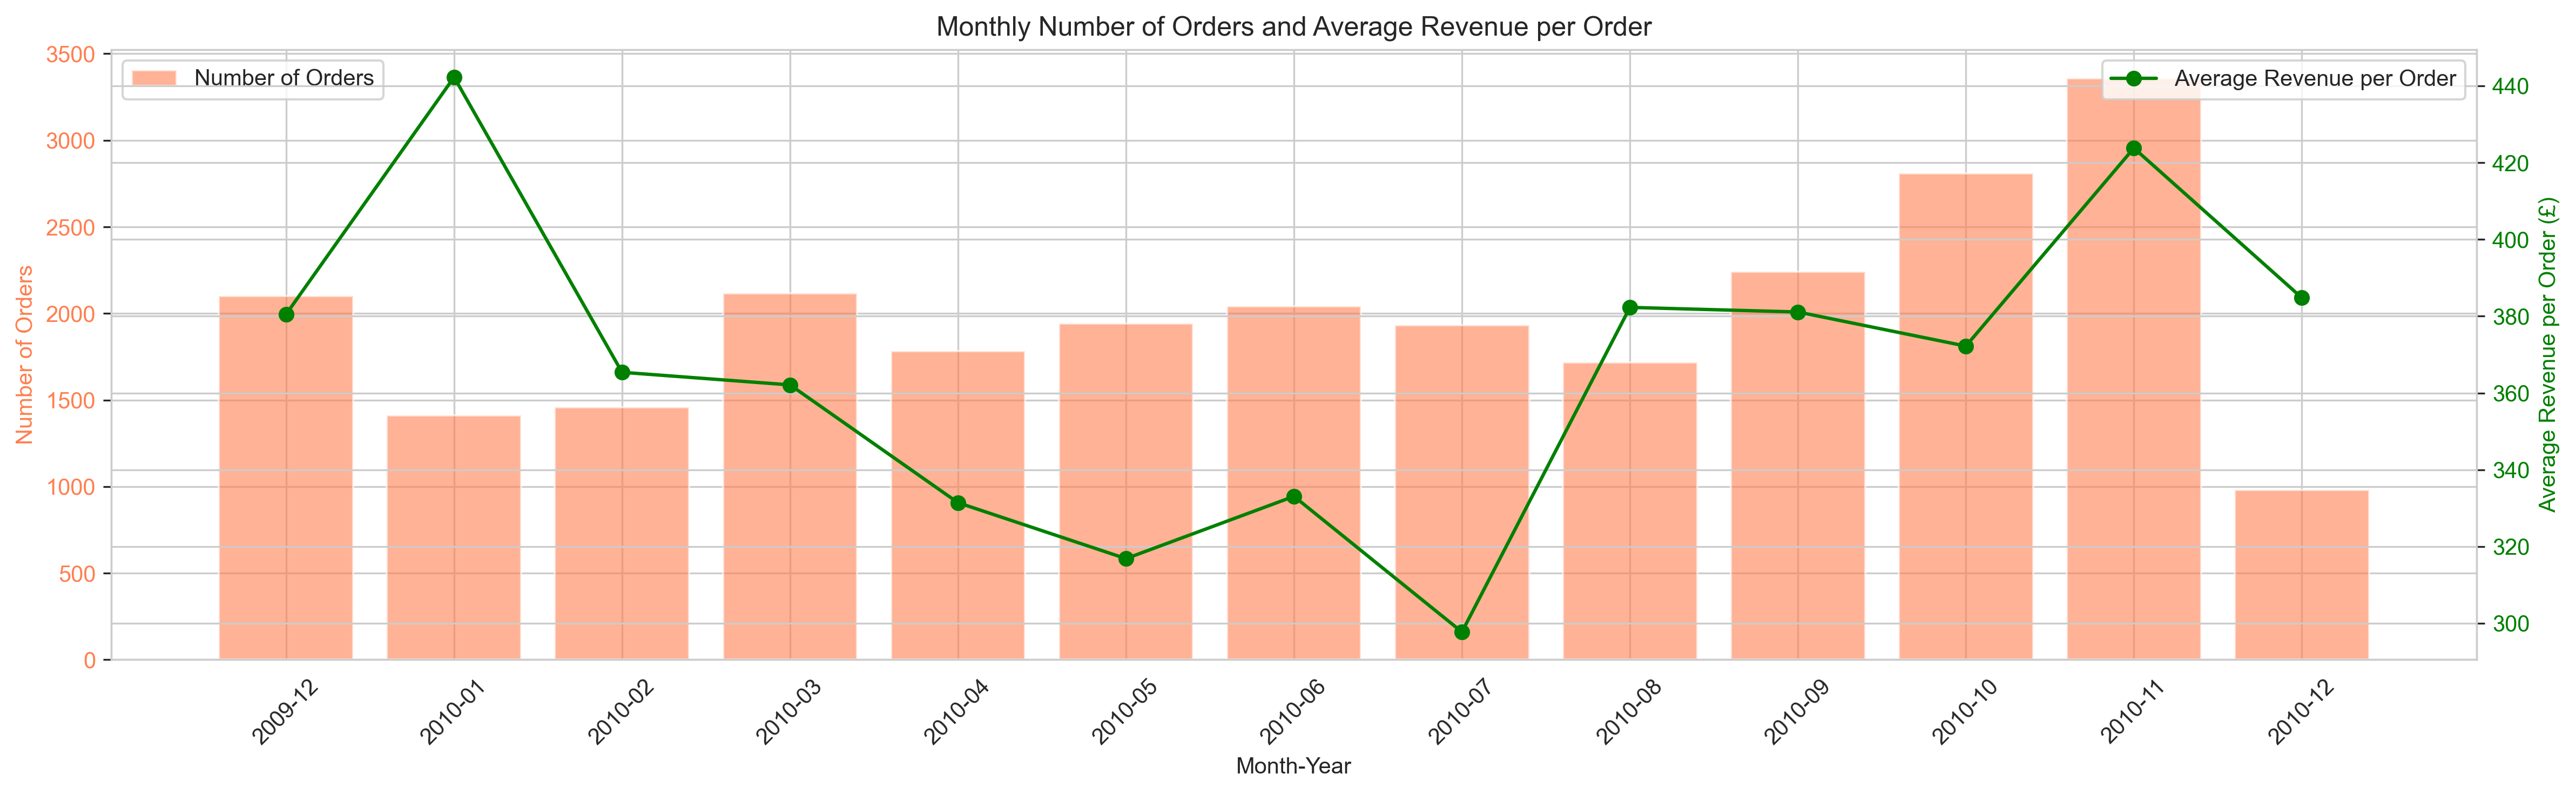

In [103]:
# Setting up the figure and axes
fig, ax1 = plt.subplots(figsize=(16, 5), dpi=300)

# Plot the "Number of Orders" on the primary y-axis
ax1.bar(
    combined_data["Month-Year"],
    combined_data["Number of Orders"],
    color="coral",
    alpha=0.6,
    label="Number of Orders",
)
ax1.set_xlabel("Month-Year")
ax1.set_ylabel("Number of Orders", color="coral")
ax1.tick_params(axis="y", labelcolor="coral")
ax1.set_title("Monthly Number of Orders and Average Revenue per Order")
ax1.set_xticks(combined_data["Month-Year"])
ax1.set_xticklabels(combined_data["Month-Year"], rotation=45)
ax1.legend(loc="upper left")

# Create the secondary y-axis for the "Average Revenue per Order"
ax2 = ax1.twinx()
ax2.plot(
    combined_data["Month-Year"],
    combined_data["Average Revenue per Order"],
    color="green",
    marker="o",
    label="Average Revenue per Order",
)
ax2.set_ylabel("Average Revenue per Order (£)", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

- The chart shows the number of orders and average revenue per order for each month from December 2009 to December 2010.
- The number of orders generally increases over the year, with peaks in September and November 2010.
- The average revenue per order remains relatively stable across months, with slight fluctuations.

### 3. CUSTOMER METRICS

In [104]:
# Identify the first purchase month for each customer using the correct column name "Customer ID"
df["FirstPurchaseMonth"] = df.groupby("Customer ID")["Month-Year"].transform("min")

# Calculate new customers for each month
new_customers = (
    df[df["Month-Year"] == df["FirstPurchaseMonth"]]
    .groupby("Month-Year")["Customer ID"]
    .nunique()
    .reset_index()
)
new_customers.columns = ["Month-Year", "New Customers"]

# Merging all together
customer_data = pd.merge(
    monthly_order_and_revenue[["Month-Year", "Number of Orders"]],
    new_customers,
    on="Month-Year",
    how="left",
)
customer_data["Existing Customers"] = (
        customer_data["Number of Orders"] - customer_data["New Customers"]
)

# Drop the Number of Orders column as it's not needed anymore
customer_data.drop("Number of Orders", axis=1, inplace=True)
customer_data

Month-Year  New Customers  Existing Customers
0     2009-12           1046                1056
1     2010-01            394                1017
2     2010-02            363                1096
3     2010-03            436                1679
4     2010-04            291                1491
5     2010-05            254                1688
6     2010-06            269                1772
7     2010-07            183                1749
8     2010-08            158                1560
9     2010-09            242                1998
10    2010-10            379                2429
11    2010-11            322                3035
12    2010-12             47                 934

#### 3.1 Number Of Customers By Type

In [107]:
total = (
    customer_data.groupby(["New Customers", "Existing Customers"]).sum().reset_index()
)
total

New Customers  Existing Customers Month-Year
0              47                 934    2010-12
1             158                1560    2010-08
2             183                1749    2010-07
3             242                1998    2010-09
4             254                1688    2010-05
5             269                1772    2010-06
6             291                1491    2010-04
7             322                3035    2010-11
8             363                1096    2010-02
9             379                2429    2010-10
10            394                1017    2010-01
11            436                1679    2010-03
12           1046                1056    2009-12

- New customers: December 2009 had the most, then it decreases as repeat purchasers increase.
- Existing customers: Steadily increases over time, indicating customer retention.

In [109]:
df["Customer Type"] = np.where(
    df["Month-Year"] == df["FirstPurchaseMonth"], "First-time", "Returning"
)
user_types = (
    df.drop_duplicates(subset=["Customer ID", "Customer Type"])
    .groupby("Customer Type")["Customer ID"]
    .count()
)
user_types

Customer Type
First-time    4384
Returning     2834
Name: Customer ID, dtype: int64

#### 3.2 Purchase Frequency

In [113]:
# Calculate Purchase Frequency
total_orders = df["Invoice"].nunique()
total_customers = df["Customer ID"].nunique()

purchase_frequency = total_orders / total_customers
purchase_frequency

5.905109489051095

- On average, a customer makes about 5.91 purchases during the period covered by the dataset.

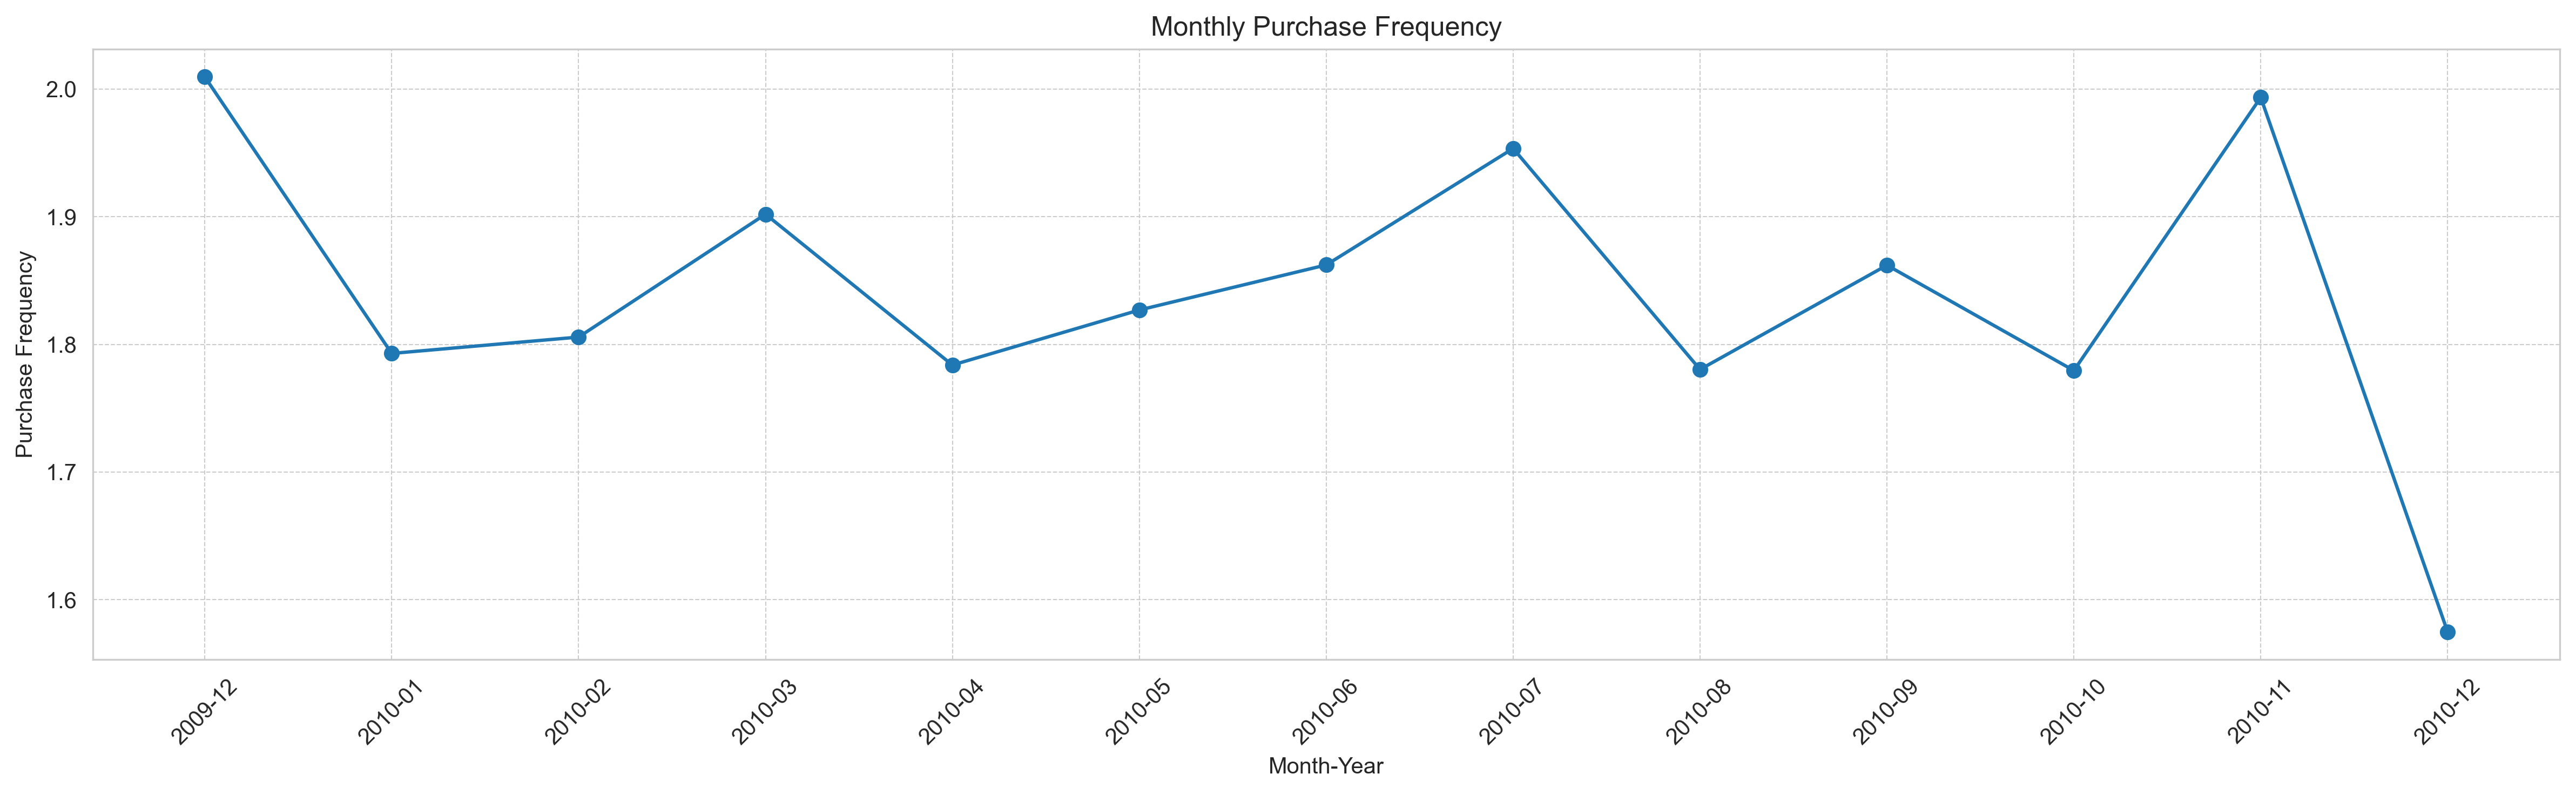

In [114]:
# Calculate monthly purchase frequency
monthly_orders = df.groupby("Month-Year")["Invoice"].nunique()
monthly_customers = df.groupby("Month-Year")["Customer ID"].nunique()

monthly_purchase_frequency = monthly_orders / monthly_customers
monthly_purchase_frequency = monthly_purchase_frequency.reset_index()
monthly_purchase_frequency.columns = ["Month-Year", "Purchase Frequency"]

# Plotting monthly purchase frequency
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(
    monthly_purchase_frequency["Month-Year"],
    monthly_purchase_frequency["Purchase Frequency"],
    marker="o",
    linestyle="-",
)
plt.title("Monthly Purchase Frequency")
plt.xlabel("Month-Year")
plt.ylabel("Purchase Frequency")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

- Purchase Frequency experiences some fluctuations over the months.
- Peaks are observed in March, July, and November 2010, indicating higher repeat purchase behavior during these months.
- There's a noticeable drop in February 2010, it can be due to various factors like: stock issues,seasonal variations and so on

##### 3.2.1 Investigating February drop

In [115]:
# Extracting relevant data for January, February, and March 2010
months_to_check = ["2010-01", "2010-02", "2010-03"]

# Monthly Revenue
monthly_revenue_subset = monthly_revenue[
    monthly_revenue["Month-Year"].isin(months_to_check)
]

# Unique Products Sold
unique_products = (
    df[df["Month-Year"].isin(months_to_check)]
    .groupby("Month-Year")["StockCode"]
    .nunique()
    .reset_index()
)
unique_products.columns = ["Month-Year", "Unique Products Sold"]

# Number of New Customers
new_customers_subset = new_customers[new_customers["Month-Year"].isin(months_to_check)]

# Merging the dataframes
analysis_df = pd.merge(
    monthly_revenue_subset, unique_products, on="Month-Year", how="left"
)
analysis_df = pd.merge(analysis_df, new_customers_subset, on="Month-Year", how="left")
analysis_df

Month-Year     Revenue  MonthlyGrowth  Unique Products Sold  New Customers
0    2010-01  624032.892          -0.22                  2719            394
1    2010-02  533091.426          -0.15                  2607            363
2    2010-03  765848.761           0.44                  2906            436

- Revenue: Drop in February, sharp rise in March. Aligns with drop in purchase frequency.
- Unique products sold: Decreased in February, increased in March. Suggests stock issues or less variety in February.
- New customers: Slightly lower in February, not significantly.

So we can say that, the drop in Purchase Frequency in February is likely due to a combination of a decrease in monthly revenue and a reduction in the variety of products available.
Basically we were right about our prediction

#### 3.4 Repeat Purchase Rate

In [116]:
customer_purchase_counts = df.groupby("Customer ID")["Invoice"].nunique()

# Identify customers with more than one purchase
repeat_customers = customer_purchase_counts[customer_purchase_counts > 1].count()

# Calculate Repeat Purchase Rate
repeat_purchase_rate = (repeat_customers / total_customers) * 100
repeat_purchase_rate

71.09945255474453

- About 71.10% of customers have made more than one purchase during the period covered by the dataset.

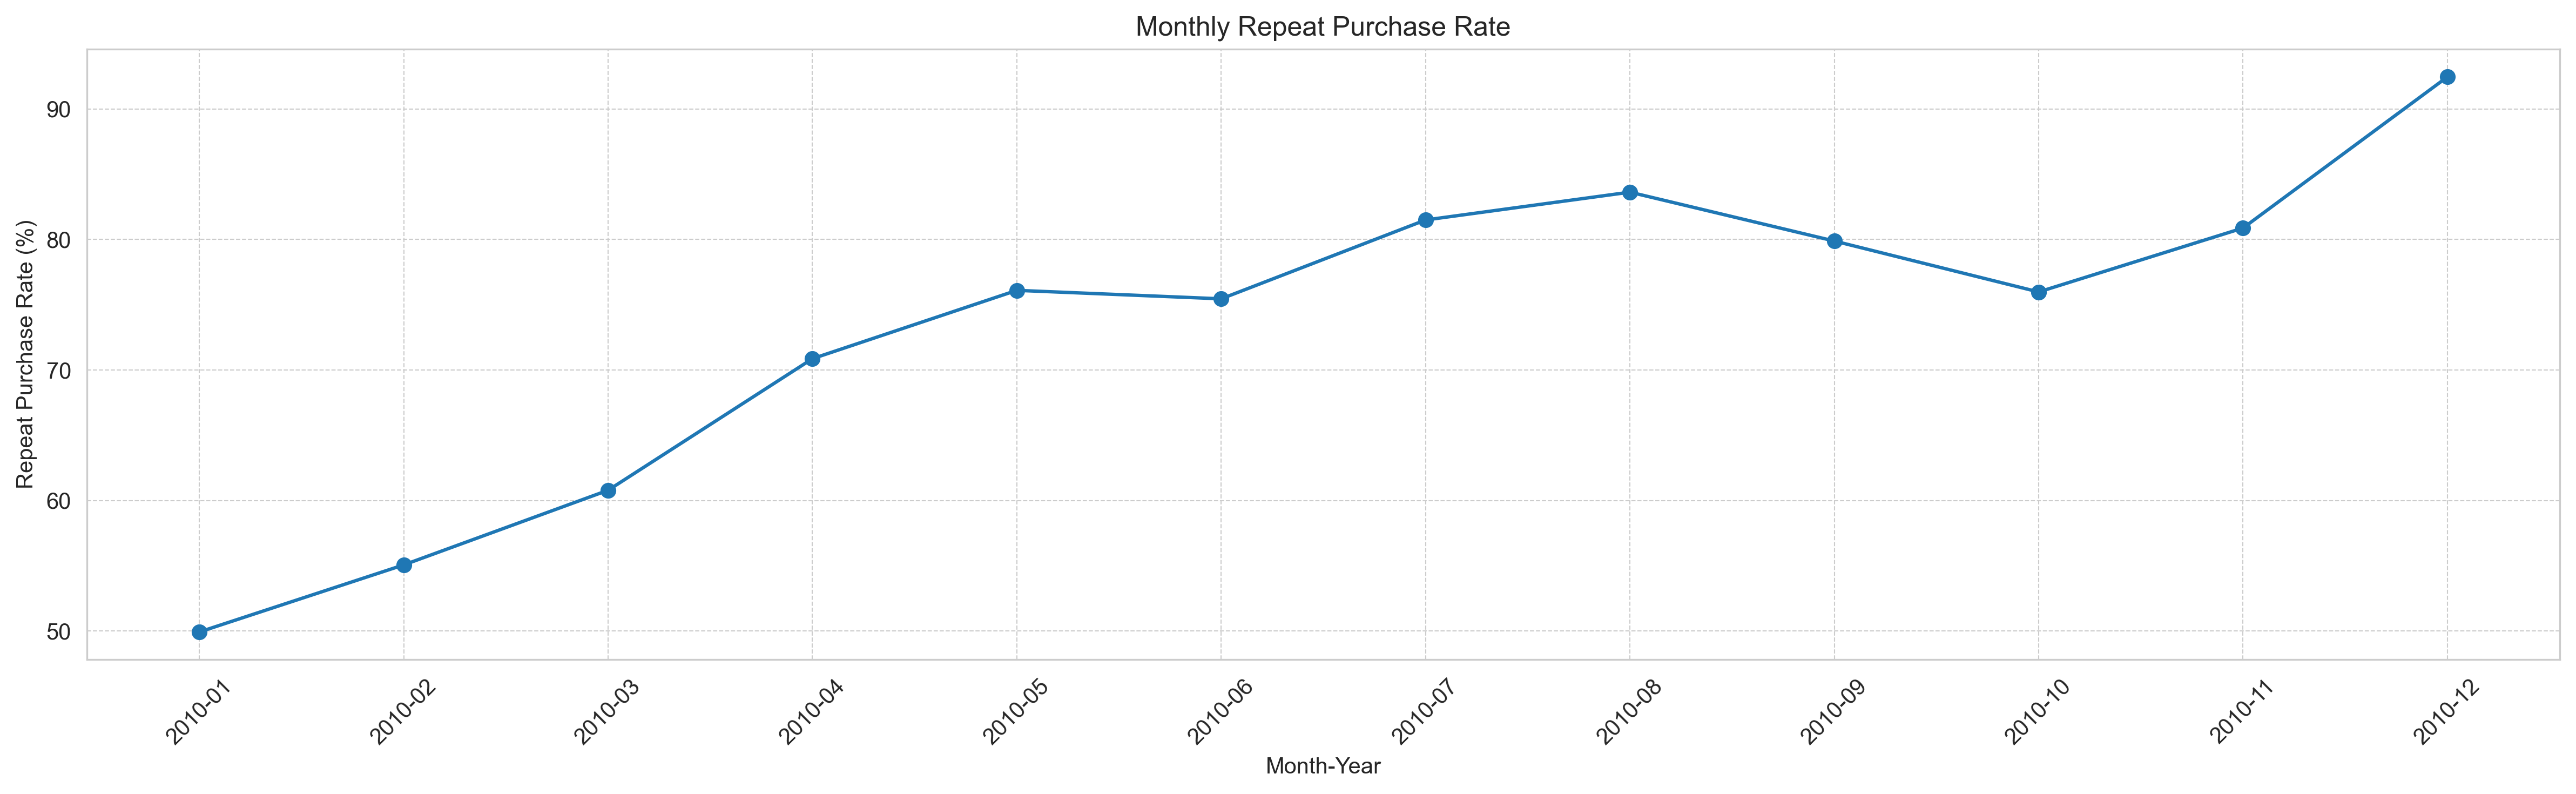

In [118]:
monthly_repeat_customers = (
    df[df["Customer Type"] == "Returning"]
    .groupby("Month-Year")["Customer ID"]
    .nunique()
)
monthly_total_customers = df.groupby("Month-Year")["Customer ID"].nunique()

# Calculate the monthly repeat purchase rate
monthly_repeat_purchase_rate = (
                                       monthly_repeat_customers / monthly_total_customers
                               ) * 100
monthly_repeat_purchase_rate = monthly_repeat_purchase_rate.reset_index()
monthly_repeat_purchase_rate.columns = ["Month-Year", "Repeat Purchase Rate"]

# Plotting
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(
    monthly_repeat_purchase_rate["Month-Year"],
    monthly_repeat_purchase_rate["Repeat Purchase Rate"],
    marker="o",
    linestyle="-",
)
plt.title("Monthly Repeat Purchase Rate")
plt.xlabel("Month-Year")
plt.ylabel("Repeat Purchase Rate (%)")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

- Hmmm, despite the slight dips in certain months, the rate remains above 60%, indicating a strong base of returning customers throughout the year.

#### 3.5 Cohort-Based Retention Rate

In [120]:
df["Cohort Month"] = (
    df.groupby("Customer ID")["InvoiceDate"].transform("min").dt.to_period("M")
)
grouped = df.groupby(["Cohort Month", "Month-Year"])
cohorts = grouped["Customer ID"].nunique().reset_index()
cohort_counts = cohorts.pivot(
    index="Cohort Month", columns="Month-Year", values="Customer ID"
)

# Calculating the number of customers in the cohort month
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Drop the first column as it's the cohort base and convert to percentage
retention = retention.iloc[:, 1:] * 100
retention

Month-Year      2010-01    2010-02    2010-03    2010-04    2010-05  \
Cohort Month                                                          
2009-12       37.571702  34.321224  42.829828  39.292543  39.101338   
2010-01             NaN        NaN        NaN        NaN        NaN   
2010-02             NaN        NaN        NaN        NaN        NaN   
2010-03             NaN        NaN        NaN        NaN        NaN   
2010-04             NaN        NaN        NaN        NaN        NaN   
2010-05             NaN        NaN        NaN        NaN        NaN   
2010-06             NaN        NaN        NaN        NaN        NaN   
2010-07             NaN        NaN        NaN        NaN        NaN   
2010-08             NaN        NaN        NaN        NaN        NaN   
2010-09             NaN        NaN        NaN        NaN        NaN   
2010-10             NaN        NaN        NaN        NaN        NaN   
2010-11             NaN        NaN        NaN        NaN        NaN   
2010-12             NaN        NaN        NaN        NaN        NaN   

Month-Year      2010-06   2010-07    2010-08    2010-09    2010-10    2010-11  \
Cohort Month                                                                    
2009-12       39.101338  35.85086  34.034417  37.571702  43.307839  49.617591   
2010-01             NaN       NaN        NaN        NaN        NaN        NaN   
2010-02             NaN       NaN        NaN        NaN        NaN        NaN   
2010-03             NaN       NaN        NaN        NaN        NaN        NaN   
2010-04             NaN       NaN        NaN        NaN        NaN        NaN   
2010-05             NaN       NaN        NaN        NaN        NaN        NaN   
2010-06             NaN       NaN        NaN        NaN        NaN        NaN   
2010-07             NaN       NaN        NaN        NaN        NaN        NaN   
2010-08             NaN       NaN        NaN        NaN        NaN        NaN   
2010-09             NaN       NaN        NaN        NaN        NaN        NaN   
2010-10             NaN       NaN        NaN        NaN        NaN        NaN   
2010-11             NaN       NaN        NaN        NaN        NaN        NaN   
2010-12             NaN       NaN        NaN        NaN        NaN        NaN   

Month-Year      2010-12  
Cohort Month             
2009-12       24.952199  
2010-01             NaN  
2010-02             NaN  
2010-03             NaN  
2010-04             NaN  
2010-05             NaN  
2010-06             NaN  
2010-07             NaN  
2010-08             NaN  
2010-09             NaN  
2010-10             NaN  
2010-11             NaN  
2010-12             NaN

- The first column (2009-12) represents the cohort size, so the retention rate is 100% (since it's the month of the first purchase).
- As we move from left to right across the table, we see the retention rate for each cohort in subsequent months.
- The NaN values indicate that the cohort did not exist during that particular month (e.g., the February 2010 cohort cannot have a retention rate for January 2010).

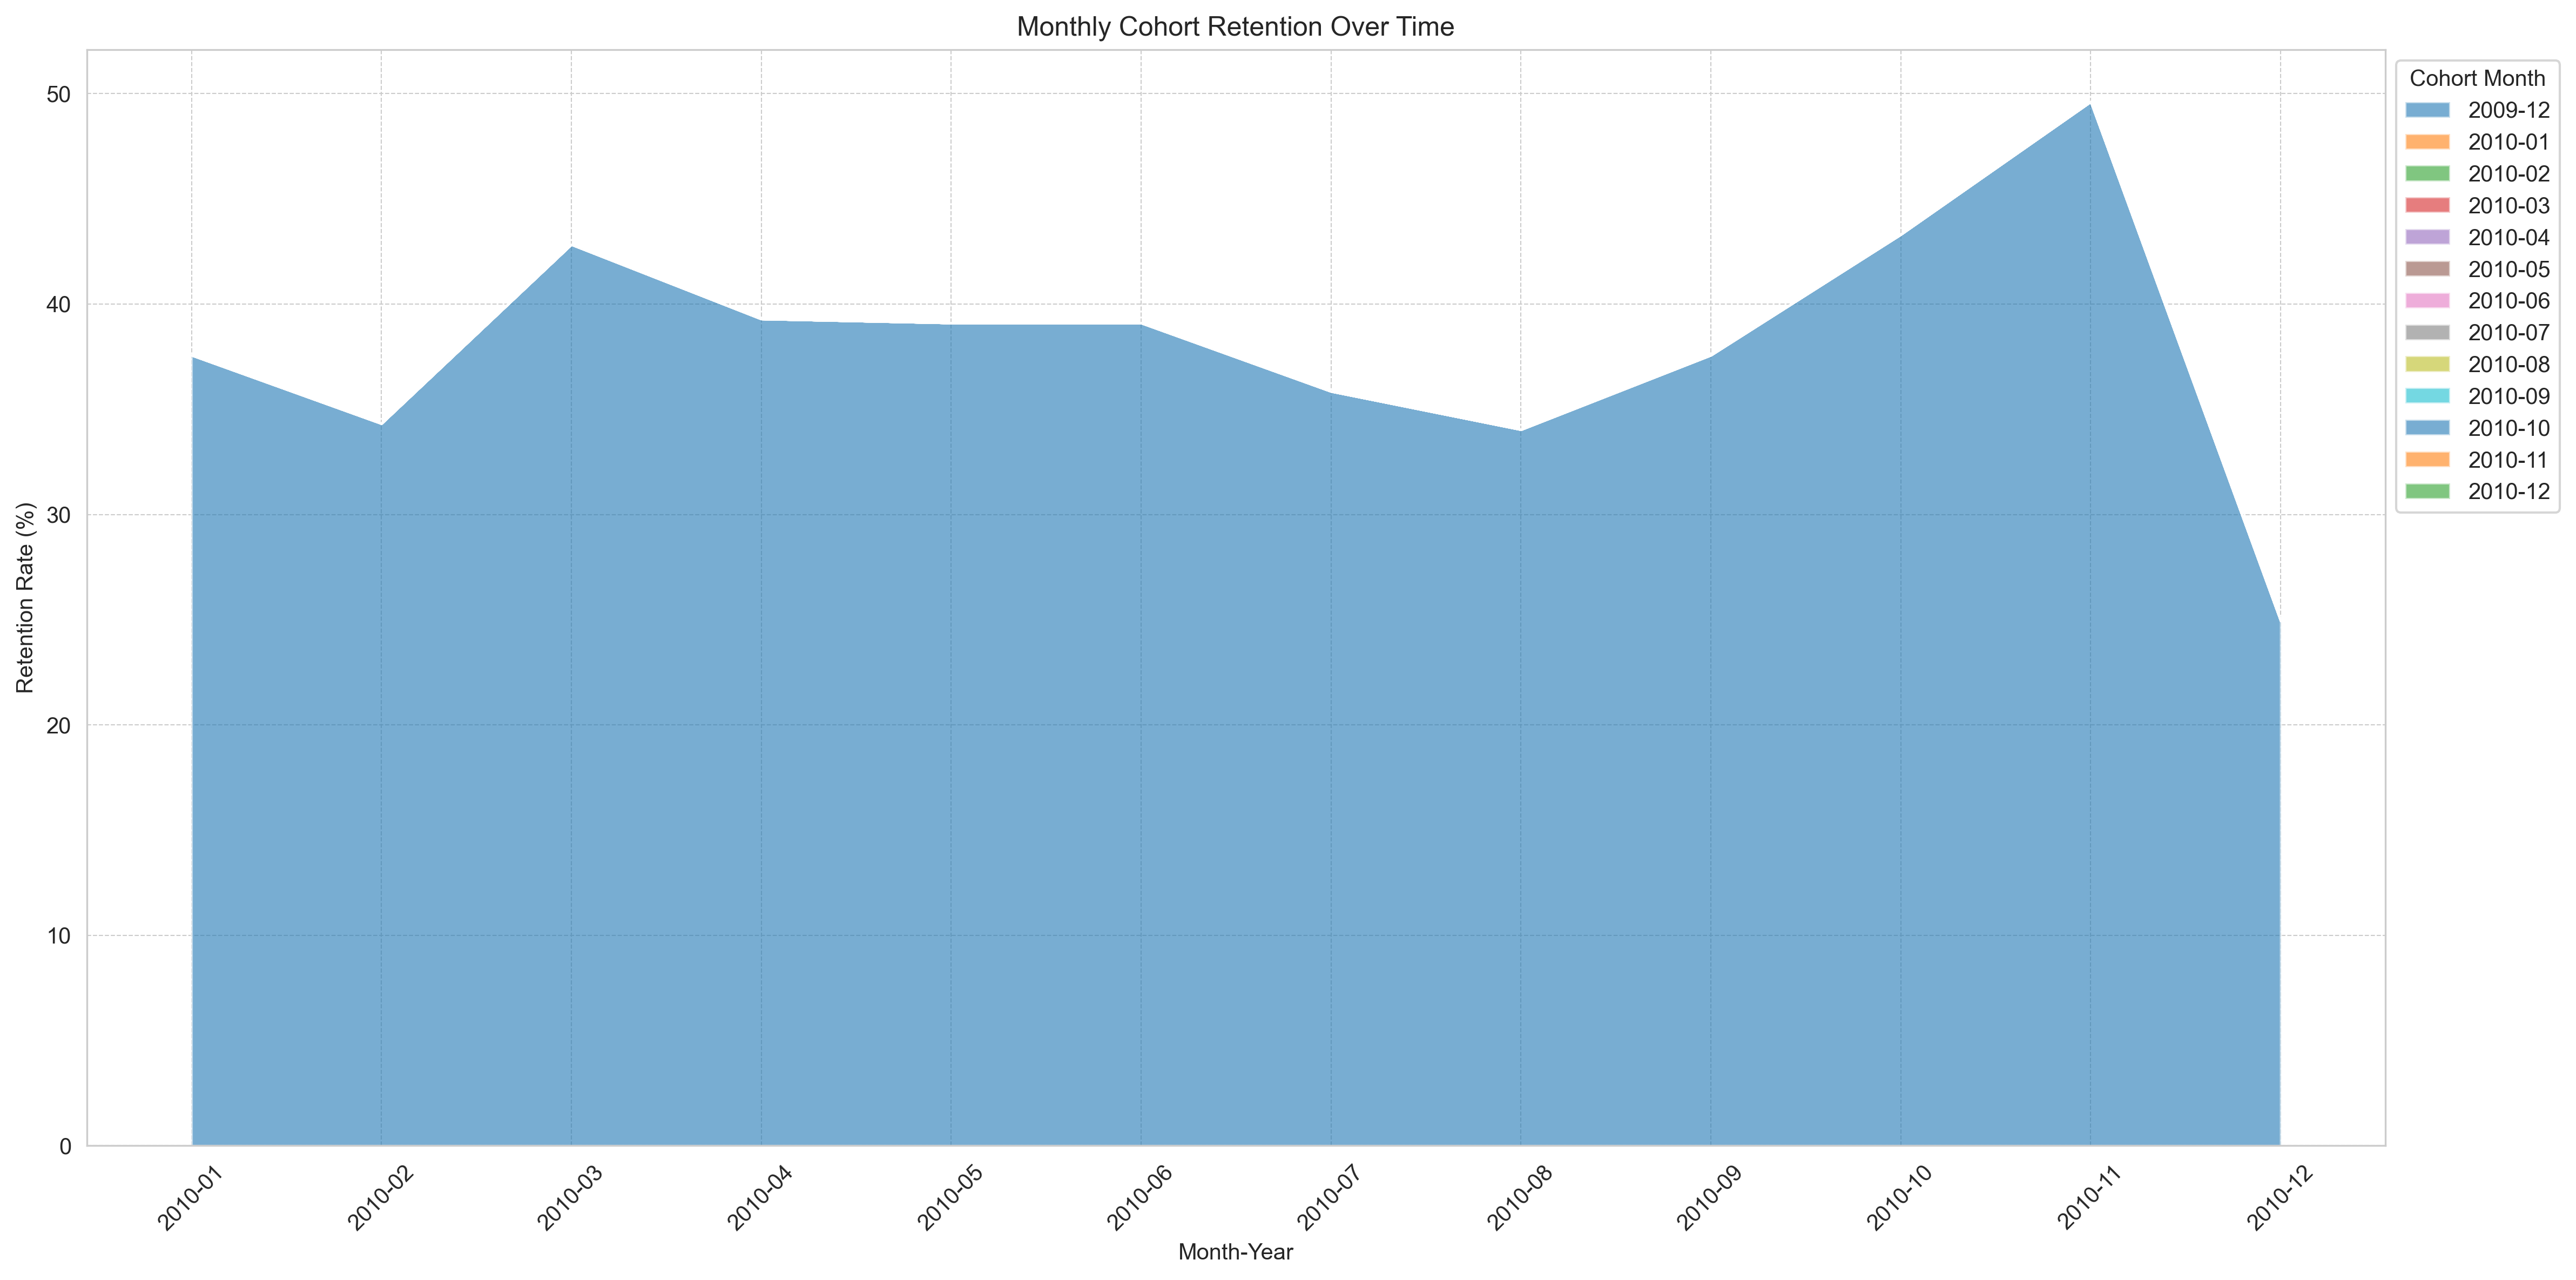

In [121]:
# Stacked area chart
retention_filled = retention.fillna(0)

plt.figure(figsize=(16, 8), dpi=300)
plt.stackplot(
    retention_filled.columns,
    retention_filled.values,
    labels=retention_filled.index,
    alpha=0.6,
)
plt.title("Monthly Cohort Retention Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Retention Rate (%)")
plt.xticks(rotation=45)
plt.legend(loc="upper left", title="Cohort Month", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

- It looks like some of them are not visible, lets go with line chart instead

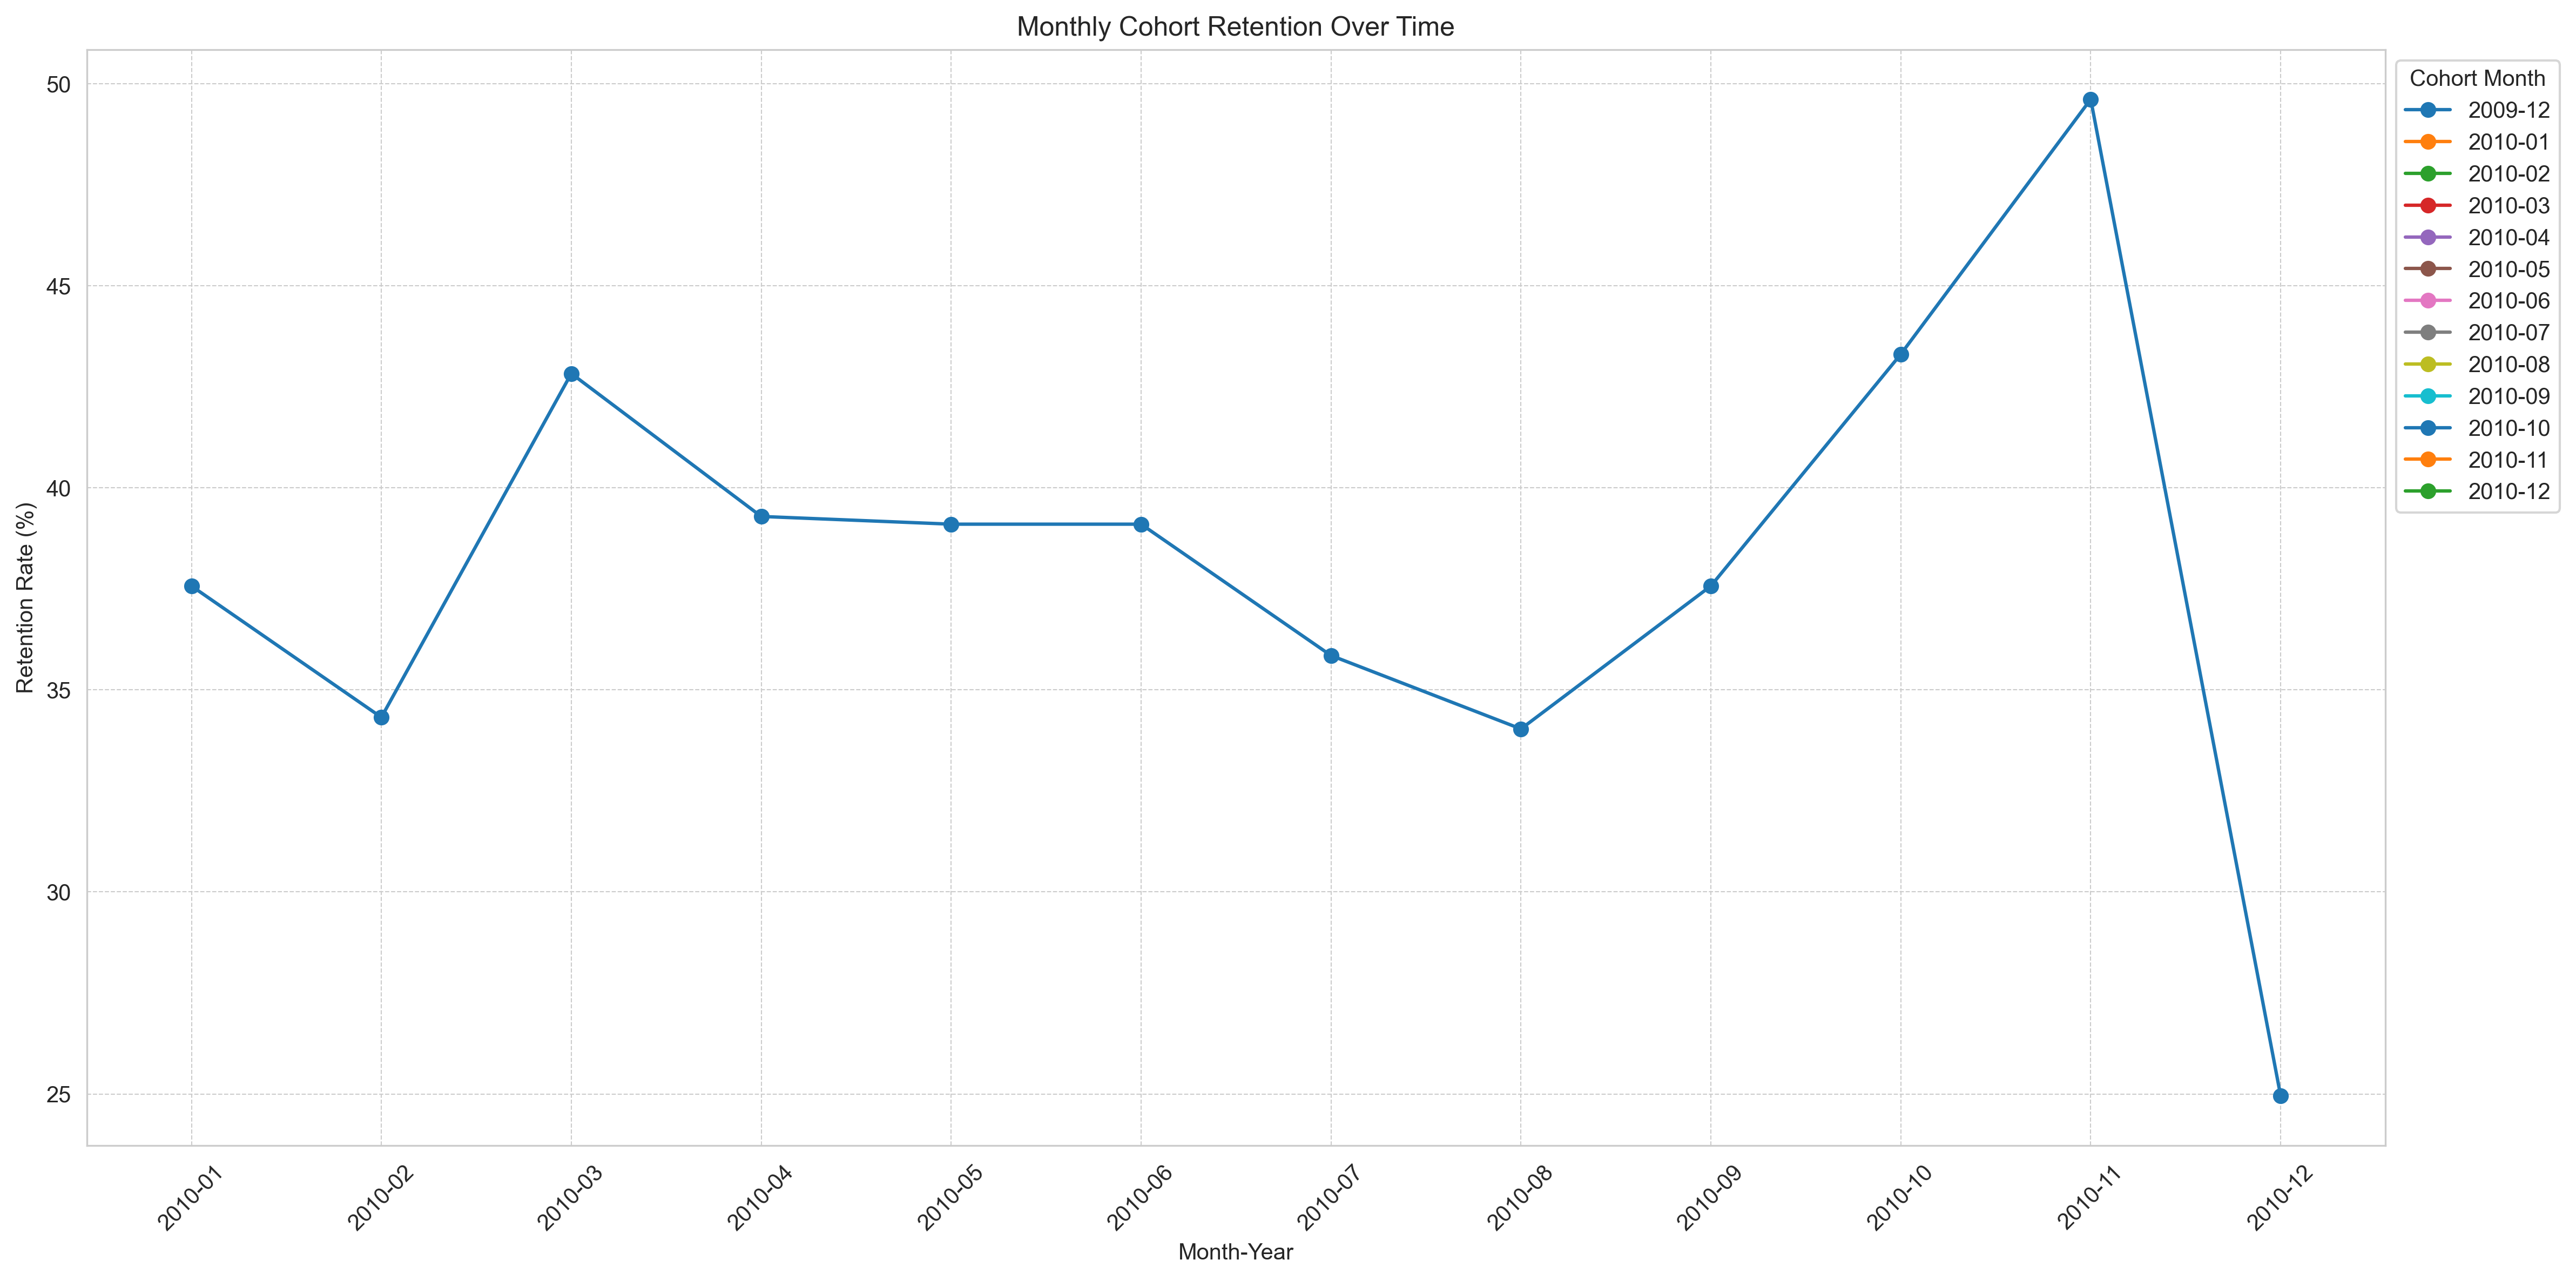

In [122]:
plt.figure(figsize=(16, 8), dpi=300)
for cohort, data in retention.iterrows():
    plt.plot(data.index, data.values, marker="o", label=cohort)

plt.title("Monthly Cohort Retention Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Retention Rate (%)")
plt.xticks(rotation=45)
plt.legend(loc="upper left", title="Cohort Month", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

- With both stacked area chart and line chart, we interpret:
    - Initial cohorts: Varying retention rates, high at start, then drop.
    - Retention drops: Visible drop in retention in months after acquisition.
    - Some cohorts stand out: March 2010 cohort has slightly increased retention.
    - Trends over time: Lines shorter for cohorts with less time to exhibit patterns.

Note: The first month's retention rate is always 100% (since it's the month of acquisition)

#### 3.6 Churn Rate

In [123]:
monthly_active_customers = df.groupby("Month-Year")["Customer ID"].nunique()

# Calculate churn rate
churn_rate = (
                     monthly_active_customers.shift(-1) - monthly_active_customers
             ) / monthly_active_customers
churn_rate = churn_rate.dropna()

# Convert to percentage
churn_rate_percentage = churn_rate * 100
churn_rate_percentage

Month-Year
2009-12   -24.760994
2010-01     2.668361
2010-02    37.623762
2010-03   -10.161871
2010-04     6.406406
2010-05     3.104421
2010-06    -9.762774
2010-07    -2.426694
2010-08    24.663212
2010-09    31.172070
2010-10     6.717364
2010-11   -63.004751
Name: Customer ID, dtype: float64

- Churn rate: Positive churn rate means customers stopped purchasing, resulting in a net loss of customers.
- December 2009: -24.76% churn rate, meaning net gain of customers in January 2010.
- November 2010: 63% churn rate, meaning significant drop in active customers in December 2010.

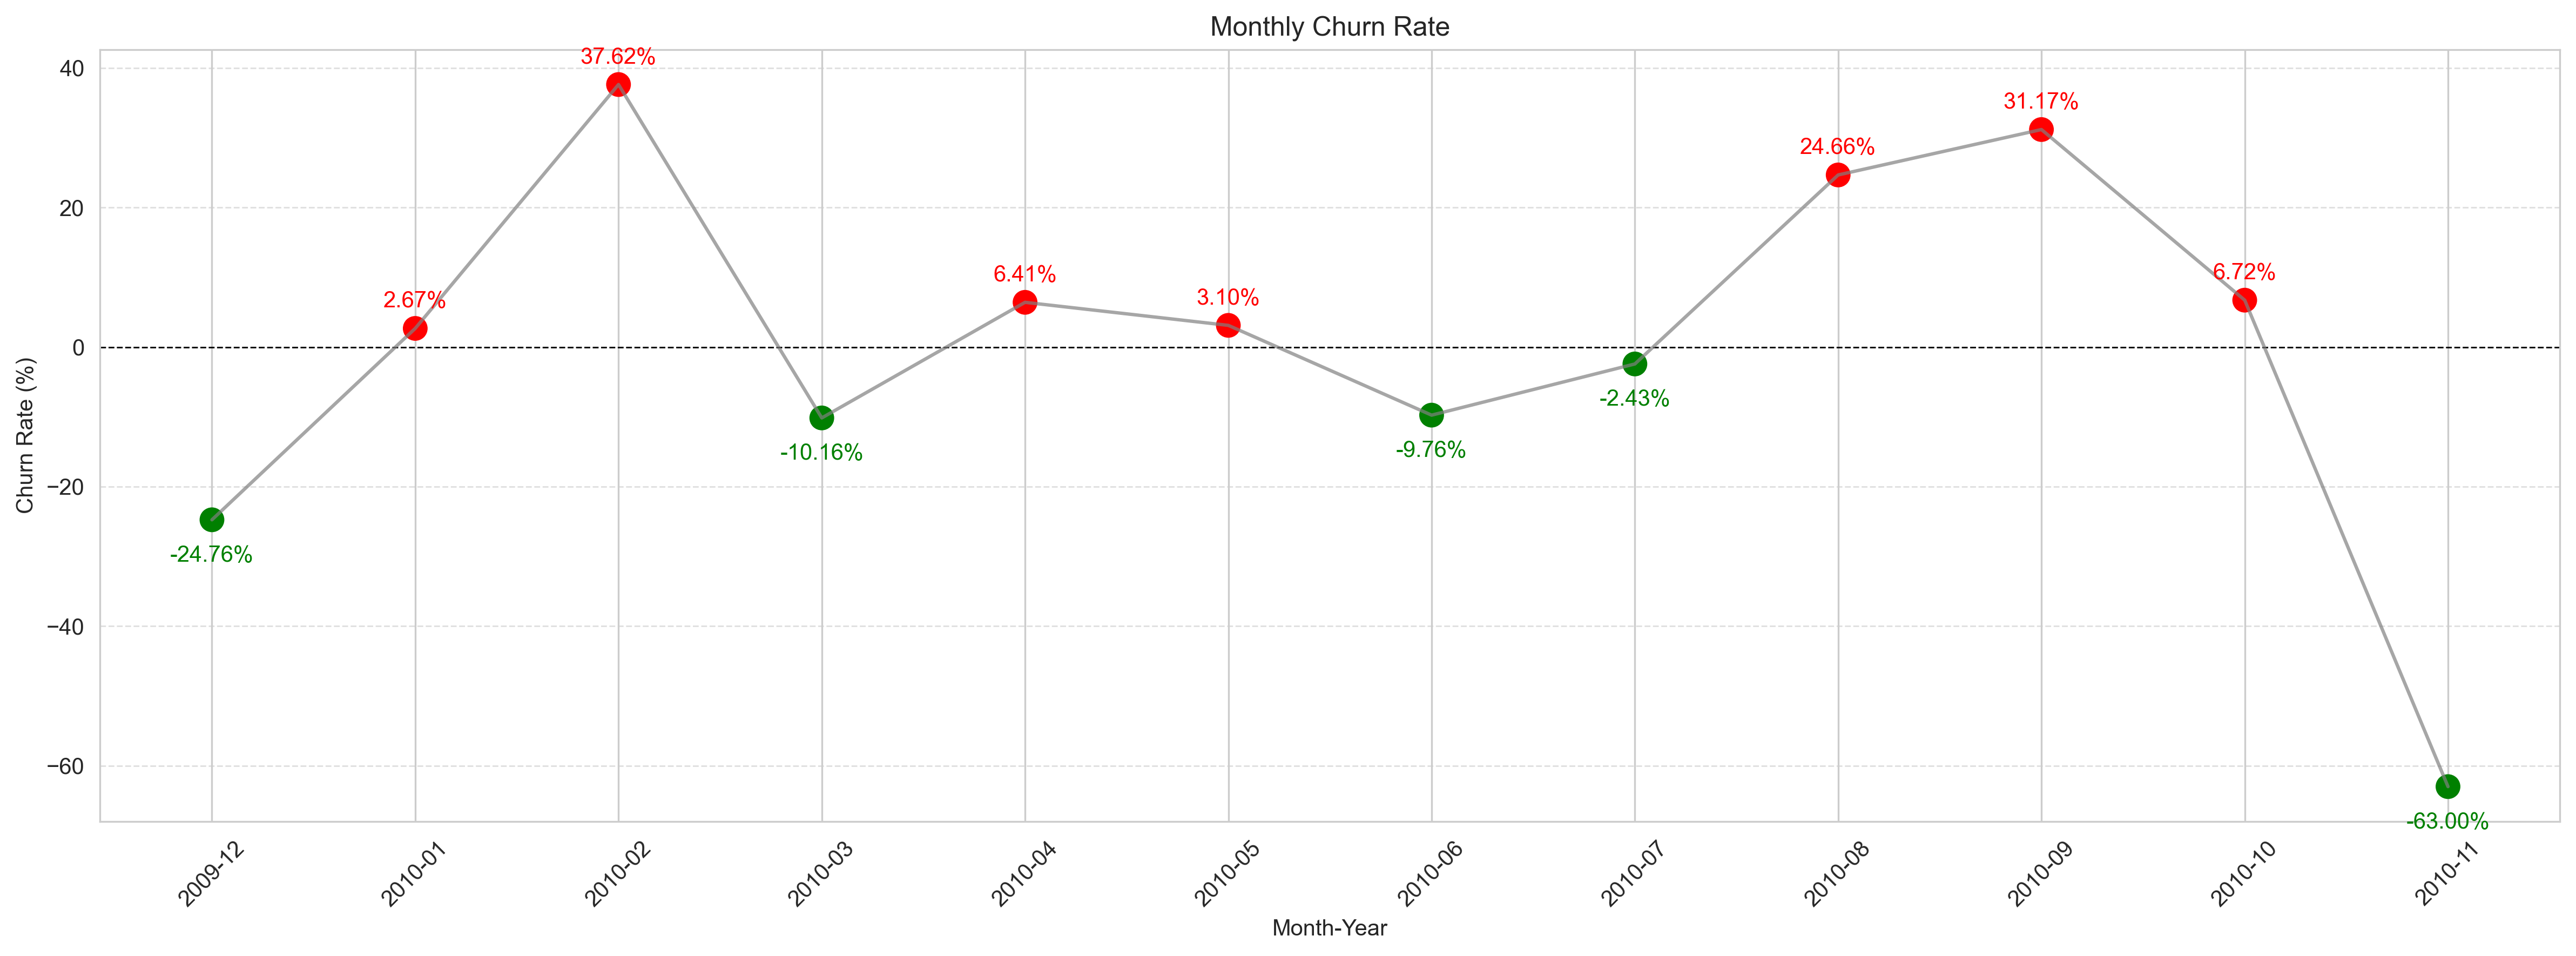

In [124]:
plt.figure(figsize=(16, 6), dpi=300)

colors = ["red" if value > 0 else "green" for value in churn_rate_percentage]
plt.axhline(
    y=0, color="black", linestyle="--", linewidth=0.7
) 
plt.scatter(churn_rate_percentage.index, churn_rate_percentage, color=colors, s=100)
plt.plot(churn_rate_percentage.index, churn_rate_percentage, color="grey", alpha=0.7)

for idx, value in enumerate(churn_rate_percentage):
    color = "red" if value > 0 else "green"
    plt.text(
        churn_rate_percentage.index[idx],
        value + 3 if value > 0 else value - 6,
        f"{value:.2f}%",
        ha="center",
        color=color,
    )

plt.title("Monthly Churn Rate")
plt.xlabel("Month-Year")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()

- Red, there's a potential problem, as more customers were lost.
- Green, things are going well with net gains in customers.

### 4. CUSTOMER SEGMENTATION USING RFM

In [126]:
most_recent_date = df["InvoiceDate"].max()

# RFM (Recency, Frequency, Monetary) calculation
rfm = df.groupby("Customer ID").agg(
    {
        "InvoiceDate": lambda x: (
                most_recent_date - x.max()
        ).days,  # Recency: days since last purchase
        "Invoice": "nunique",  # Frequency: total number of unique invoices (orders)
        "TotalRevenue": "sum",  # Monetary Value: total money spent
    }
)

rfm.columns = ["Recency", "Frequency", "MonetaryValue"]
rfm.head()

Recency  Frequency  MonetaryValue
Customer ID                                   
-1                 0       2301     1191276.06
 12346            66         15         -64.68
 12347             2          2        1323.32
 12348            73          1         222.16
 12349            42          4        2646.99

- Recency (R): Number of days since their last purchase.
- Frequency (F): Total number of unique invoices or orders they've made.
- MonetaryValue (M): Total money they've spent.

In [127]:
# Scoring out of 5
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
)
rfm["M_Score"] = pd.qcut(rfm["MonetaryValue"], 5, labels=[1, 2, 3, 4, 5])

# Combining the RFM scores
rfm["RFM_Segment"] = (
        rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].sum(axis=1)

rfm.head()

Recency  Frequency  MonetaryValue R_Score F_Score M_Score  \
Customer ID                                                              
-1                 0       2301     1191276.06       5       5       5   
 12346            66         15         -64.68       3       5       1   
 12347             2          2        1323.32       5       2       4   
 12348            73          1         222.16       2       1       1   
 12349            42          4        2646.99       3       3       5   

            RFM_Segment  RFM_Score  
Customer ID                         
-1                  555         15  
 12346              351          9  
 12347              524         11  
 12348              211          4  
 12349              335         11

Let's create meaningful segments or groups:

- Champions: Bought recently, buy often, and spend the most.
- Loyal Customers: Buy on a regular basis. Responsive to promotions.
- Potential Loyalists: Recent customers with high potential.
- Recent Customers: Bought most recently, but not often.
- Promising: Recent shoppers, but haven’t spent much.
- At Risk: Purchased often but a long time ago. Need to be re-engaged.
- Hibernating: Last purchase was long back, low spenders and low frequency.

In [129]:
def segment_rfm(row):
    if row['RFM_Score'] >= 13:
        return 'Champion'
    elif row['RFM_Score'] >= 11:
        return 'Loyal Customer'
    elif row['RFM_Score'] >= 9:
        return 'Potential Loyalist'
    elif row['RFM_Score'] >= 7:
        return 'Recent Customer'
    elif row['RFM_Score'] >= 5:
        return 'Promising'
    elif row['RFM_Score'] >= 3:
        return 'At Risk'
    else:
        return 'Hibernating'

# Segmenting customers based on RFM scores
rfm['RFM_Level'] = rfm.apply(segment_rfm, axis=1)
rfm_level_counts = rfm['RFM_Level'].value_counts()

rfm_level_counts

Champion              943
Recent Customer       767
Potential Loyalist    720
Promising             712
Loyal Customer        680
At Risk               562
Name: RFM_Level, dtype: int64

- Overall , it seems like we don't have any customers falling into the "Hibernating" category.
- "At Risk" customers might require some re-engagement strategies.

#### 4.1 Exploring "At Risk" Customers

In [130]:
at_risk = rfm[rfm["RFM_Level"] == "At Risk"]
at_risk_behavior = at_risk[["Recency", "Frequency", "MonetaryValue"]].describe()

at_risk_behavior

Recency   Frequency  MonetaryValue
count  562.000000  562.000000     562.000000
mean   249.542705    1.051601     113.128774
std     81.611329    0.221418     378.127822
min     70.000000    1.000000   -5876.340000
25%    196.000000    1.000000      93.312500
50%    256.000000    1.000000     146.980000
75%    315.000000    1.000000     212.812500
max    373.000000    2.000000     454.360000

- Recency: Average time since last purchase is 250 days.
- Frequency: Average number of purchases is slightly above 1.
- Monetary value: Average spend is £113.

If we were to elaborate in more mannered way, we can say:
- The average time since the last purchase of 250 days indicates that these customers are not very active.
- The average number of purchases of slightly above 1 indicates that most of these customers have only made one purchase.
- The average spend of £113 is not very high, but there is a wide range of spending, from -£5876.34 to £454.36.

 With this, we can confidently say that it's clear that these customers have made purchases in the past but have not been active recently. Most of them have made only one purchase, which indicates they might need some encouragement or a compelling reason to return.

##### 4.1.2 Top Products Purchased By "At Risk" Customers

In [131]:
at_risk_customers = df[df["Customer ID"].isin(at_risk.index)]

# Identify top products they've purchased
top_products_at_risk = (
    at_risk_customers.groupby("Description")
    .agg({"Quantity": "sum"})
    .sort_values(by="Quantity", ascending=False)
    .head(10)
)

top_products_at_risk

Quantity
Description                                  
CHINESE DRAGON PAPER LANTERNS             804
DINOSAUR KEYRINGS ASSORTED                720
ANTIQUE SILVER TEA GLASS ENGRAVED         662
FENG SHUI PILLAR CANDLE                   600
STRAWBERRY CERAMIC TRINKET BOX            544
WHITE HANGING HEART T-LIGHT HOLDER        445
COLOUR GLASS T-LIGHT HOLDER HANGING       392
GRAND CHOCOLATECANDLE                     379
PACK OF 60 PINK PAISLEY CAKE CASES        354
BROCADE RING PURSE                        331

- Knowing the top products can guide the marketing and sales teams in crafting targeted promotions or offers to re-engage these "At Risk" customers.

##### 4.1.3 Purchase Timing Of The "At Risk" Customers

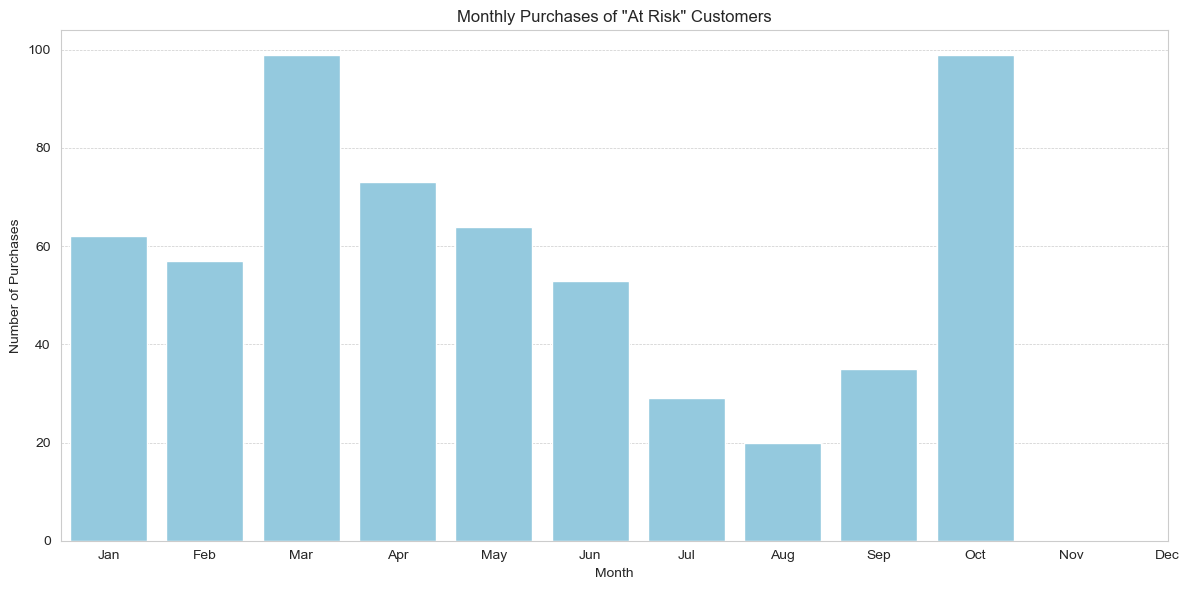

In [134]:
at_risk_customers["PurchaseMonth"] = at_risk_customers["InvoiceDate"].dt.month

# Count purchases in each month
monthly_purchases_at_risk = (
    at_risk_customers.groupby("PurchaseMonth").agg({"Invoice": "nunique"}).reset_index()
)
monthly_purchases_at_risk.columns = ["Month", "Number of Purchases"]

# Visualize the monthly purchases
plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_purchases_at_risk, x="Month", y="Number of Purchases", color="skyblue"
)
plt.title('Monthly Purchases of "At Risk" Customers')
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.xticks(
    ticks=range(0, 12),
    labels=[
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, axis="y")
plt.tight_layout()
plt.show()

- At Risk segment: Most purchases in November and December, fewest in January.
- Holiday season: Strong inclination towards holiday season shopping.
- Summer months: Noticeable dip in purchases, suggesting customers might not be as engaged.

#### 4.2 "Champions" Segment Analysis

In [136]:
# RFM calculations
recency = df.groupby("Customer ID").InvoiceDate.max().reset_index()
recency["Recency"] = (recency["InvoiceDate"].max() - recency["InvoiceDate"]).dt.days
frequency = df.groupby("Customer ID").InvoiceDate.count().reset_index()
frequency.columns = ["Customer ID", "Frequency"]
monetary = df.groupby("Customer ID").TotalRevenue.sum().reset_index()
rfm = recency.merge(frequency, on="Customer ID")
rfm = rfm.merge(monetary, on="Customer ID")
rfm.set_index("Customer ID", inplace=True)

# Segmentation
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
r_quartiles = pd.qcut(rfm["Recency"], 4, labels=r_labels)
f_quartiles = pd.qcut(rfm["Frequency"], 4, labels=f_labels)
m_quartiles = pd.qcut(rfm["TotalRevenue"], 4, labels=m_labels)
rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)
rfm["RFM_Segment"] = rfm.apply(
    lambda x: str(x["R"]) + str(x["F"]) + str(x["M"]), axis=1
)
rfm["RFM_Score"] = rfm[["R", "F", "M"]].sum(axis=1)

# Define rfm_level function
def rfm_level(df):
    if df["RFM_Score"] >= 9:
        return "Champions"
    elif (df["RFM_Score"] >= 8) and (df["RFM_Score"] < 9):
        return "Loyal"
    elif (df["RFM_Score"] >= 7) and (df["RFM_Score"] < 8):
        return "Potential"
    elif (df["RFM_Score"] >= 6) and (df["RFM_Score"] < 7):
        return "Promising"
    elif (df["RFM_Score"] >= 5) and (df["RFM_Score"] < 6):
        return "Needs Attention"
    else:
        return "Require Activation"


# Create a new variable RFM_Level
rfm["RFM_Level"] = rfm.apply(rfm_level, axis=1)

# Filter out Champions
champions_customers = rfm[rfm["RFM_Level"] == "Champions"]


champions_data = df[df["Customer ID"].isin(champions_customers.index)]
champions_country_distribution = (
    champions_data.groupby("Country").agg({"Customer ID": "nunique"}).reset_index()
)
champions_country_distribution.columns = ["Country", "Number of Customers"]
champions_country_distribution = champions_country_distribution.sort_values(
    by="Number of Customers", ascending=False
)

champions_country_distribution.head(10)

Country  Number of Customers
34   United Kingdom                 1549
12          Germany                   32
11           France                   27
3           Belgium                   10
31      Switzerland                    8
29            Spain                    8
22      Netherlands                    8
30           Sweden                    7
6   Channel Islands                    7
16            Italy                    6

- As expected, UK is on top cause of its enormous data this dataset.

In [137]:
# Top products for the 'Champions' segment
top_products_champions = (
    champions_data.groupby("Description").agg({"Quantity": "sum"}).reset_index()
)
top_products_champions = top_products_champions.sort_values(
    by="Quantity", ascending=False
).head(10)

top_products_champions

Description  Quantity
4474   WORLD WAR 2 GLIDERS ASSTD DESIGNS     50321
4367  WHITE HANGING HEART T-LIGHT HOLDER     48041
278        ASSORTED COLOUR BIRD ORNAMENT     40643
2721    PACK OF 72 RETRO SPOT CAKE CASES     40579
720                  BROCADE RING PURSE      39406
146          60 TEATIME FAIRY CAKE CASES     31479
3955                SMALL POPCORN HOLDER     28603
2719  PACK OF 60 PINK PAISLEY CAKE CASES     28301
2140             JUMBO BAG RED RETROSPOT     28166
2723         PACK OF 72 SKULL CAKE CASES     23468

#### 4.3 Exploring Leftover Segments

In [138]:
# Merging the RFM segment data with the main dataframe
df_rfm = pd.merge(df, rfm["RFM_Level"], left_on="Customer ID", right_index=True)
segment_data = {}

segment_data["Number of Customers"] = df_rfm.groupby("RFM_Level")[
    "Customer ID"
].nunique()

segment_data["Total Revenue"] = df_rfm.groupby("RFM_Level")["TotalRevenue"].sum()

segment_data["Average Order Value"] = df_rfm.groupby("RFM_Level")["TotalRevenue"].mean()

segment_data["Purchase Frequency"] = (
        df_rfm.groupby("RFM_Level")["Invoice"].nunique() / df_rfm["Customer ID"].nunique()
)


segment_summary = pd.DataFrame(segment_data).reset_index()
segment_summary

RFM_Level  Number of Customers  Total Revenue  \
0           Champions                 1700    8259115.389   
1               Loyal                  459     517230.283   
2     Needs Attention                  458     147823.900   
3           Potential                  492     342659.550   
4           Promising                  459     224270.741   
5  Require Activation                  816      48384.771   

   Average Order Value  Purchase Frequency  
0            18.612552            4.537409  
1            19.461575            0.382984  
2            14.964963            0.182482  
3            16.980156            0.313412  
4            17.201315            0.226049  
5             5.304766            0.262774

- Champions: Top revenue contributors, high purchase frequency, high average order value.
- Loyal customers: High average order value, low purchase frequency.
- Customers who Need Attention: Low revenue, low average order value, low purchase frequency.
- Require Activation: Low revenue, low average order value, high purchase frequency.
- Potential and Promising: Somewhere in between, show potential for growth.

### 5. Time Series Decomposition

In [142]:
# Calculate daily revenue
daily_revenue = (
    df.groupby(df["InvoiceDate"].dt.date)
    .apply(lambda x: (x["Quantity"] * x["Price"]).sum())
    .reset_index()
)
daily_revenue.columns = ["Date", "Revenue"]
daily_revenue.set_index("Date", inplace=True)

daily_revenue.head()

Revenue
Date                
2009-12-01  53173.03
2009-12-02  62763.59
2009-12-03  68093.05
2009-12-04  40346.40
2009-12-05   9803.05

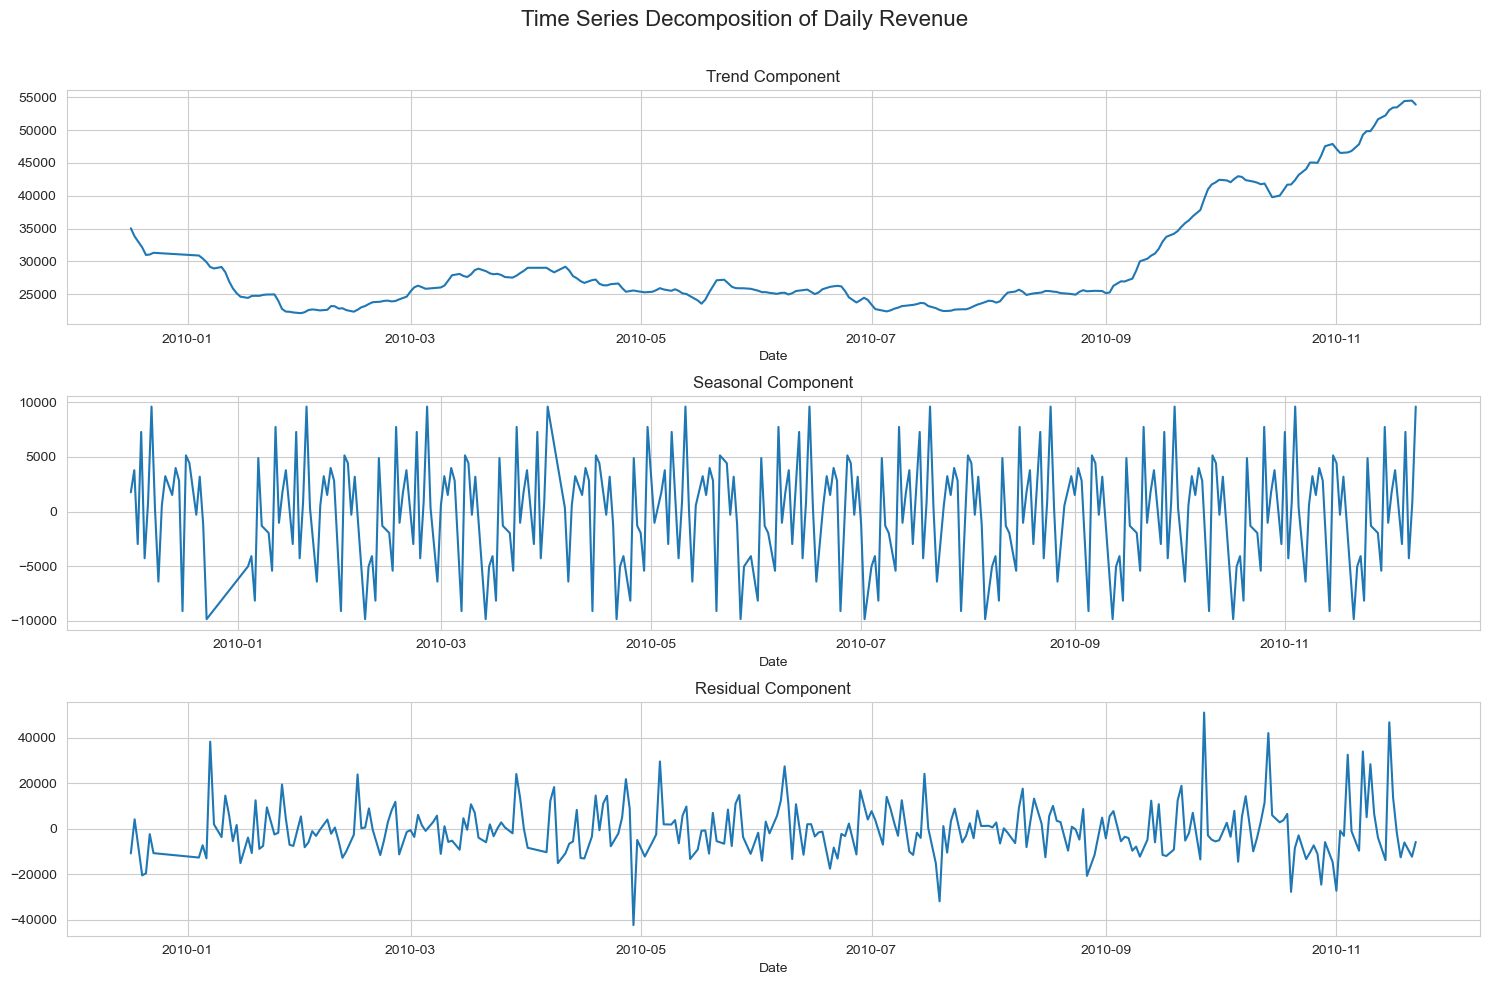

In [147]:
decomposition = seasonal_decompose(daily_revenue, model="additive", period=30)

# Plot the decomposed time series components
plt.figure(figsize=(15, 10))
plt.suptitle("Time Series Decomposition of Daily Revenue", fontsize=16)

# Plot trend
plt.subplot(3, 1, 1)
decomposition.trend.plot(ax=plt.gca())
plt.title("Trend Component")

# Plot seasonal
plt.subplot(3, 1, 2)
decomposition.seasonal.plot(ax=plt.gca())
plt.title("Seasonal Component")

# Plot residuals
plt.subplot(3, 1, 3)
decomposition.resid.plot(ax=plt.gca())
plt.title("Residual Component")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

- The trend component is important for understanding the long-term direction of the data. In this case, the revenue is generally increasing, but there are some fluctuations. This could be due to a number of factors, such as promotions, holidays, or external events.
- The seasonality component is important for understanding the regular patterns in the data. In this case, there is a clear monthly seasonality, with revenue increasing in some months and decreasing in others. This could be due to a number of factors we assumed before, such as holidays, or consumer spending habits etc.
- The residual component is important for understanding the random fluctuations in the data. This is the component of the time series that can't be attributed to the trend or seasonality.

In [150]:
# Augmented Dickey-Fuller test on daily revenue data
adf_result = adfuller(daily_revenue['Revenue'])

adf_statistic = adf_result[0]
adf_pvalue = adf_result[1]

adf_statistic, adf_pvalue

(-1.6774617557355502, 0.4427606632545204)

- The Augmented Dickey-Fuller test gives −1.677 and a p-value of 0.44.
- Our p-value is 0.44, which is considerably higher than 0.05.
- This indicates that our series is non-stationary.

#### 5.1 Outliners Detection

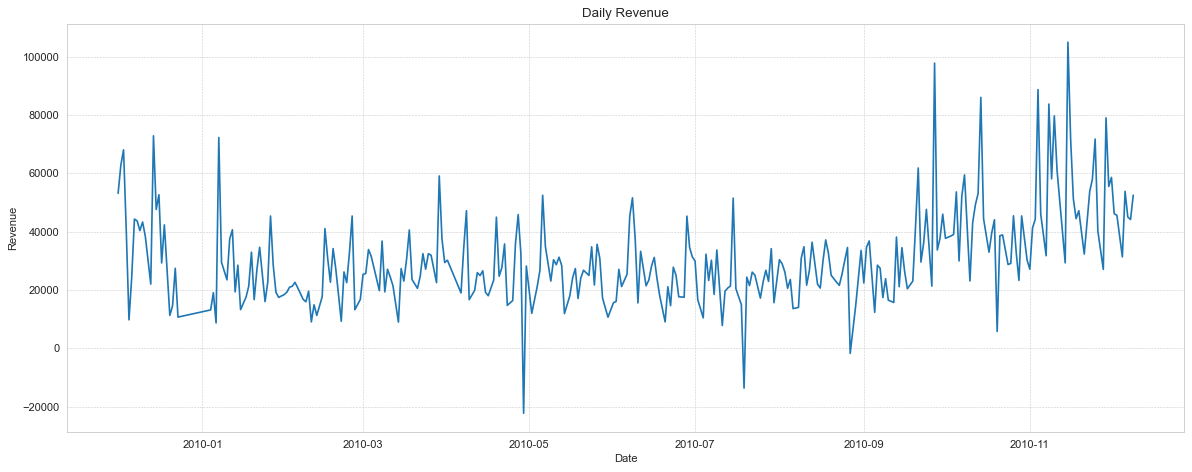

In [151]:
plt.figure(figsize=(15, 6), dpi=80)
daily_revenue['Revenue'].plot(title="Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

- From the plot, we can observe some spikes that could potentially be outliers. Let's dive more deeper into this and see what we can get.

In [152]:
# Computing IQR
Q1 = daily_revenue["Revenue"].quantile(0.25)
Q3 = daily_revenue["Revenue"].quantile(0.75)
IQR = Q3 - Q1

# Determining bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying potential outliers
outliers = daily_revenue[
    (daily_revenue["Revenue"] < lower_bound) | (daily_revenue["Revenue"] > upper_bound)
    ]
outliers

Revenue
Date                  
2009-12-03   68093.050
2009-12-14   72898.240
2010-01-07   72307.920
2010-04-29  -22212.609
2010-07-19  -13595.880
2010-09-27   97814.700
2010-10-14   86077.650
2010-11-04   88738.310
2010-11-08   83788.851
2010-11-10   79721.720
2010-11-15  104983.550
2010-11-16   71633.720
2010-11-25   71788.180
2010-11-29   79069.770

- We have days with very high revenues, like on 2009-12-03, 2009-12-14, and 2010-11-15.
- Interestingly, we also have days with negative revenues, like on 2010-04-29 and 2010-07-19. These could be due to returns or cancellations.

So here, we got few options:
1. Leave the outliers
2. Remove the outliers
3. Replace the outliers

Let's try:
- Negative revenues: Replacing with zeroes.
- High revenue outliers: Leave as they are.

Why you may ask?:
- Negative revenues are a part of business operations, but they are not relevant for forecasting future revenues. Replacing them with zeroes will help to ensure that the forecasting models are not biased by these negative values.
- High revenue outliers can be important indicators of future trends. For example, if there is a sudden spike in revenue due to a promotion, then the forecasting models should be able to capture this trend and predict higher revenue in the future. Removing or altering these outliers could cause the models to under-predict future revenue.

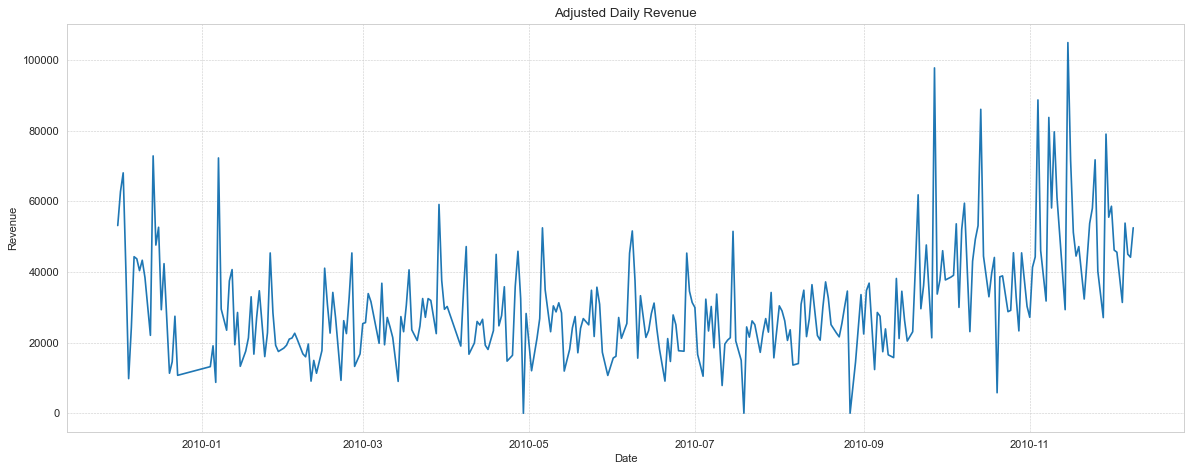

In [153]:
# Replace negative revenues with 0
daily_revenue["Revenue"] = daily_revenue["Revenue"].apply(lambda x: 0 if x < 0 else x)

plt.figure(figsize=(15, 6), dpi=80)
daily_revenue["Revenue"].plot(title="Adjusted Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

- This graph displays the adjusted revenues, where negative revenue days have been replaced with zeroes. The high revenue days remain unchanged.

### 5. Machine Learning Models

#### 5.1 RFM Classification

In [238]:
df_cleaned = pd.read_csv("cleaned.csv", parse_dates=["InvoiceDate"])

# Calculate the 'TotalCost' column
df_cleaned["TotalCost"] = df_cleaned["Quantity"] * df_cleaned["Price"]

# Calculate Recency, Frequency, and MonetaryValue
max_date = df_cleaned["InvoiceDate"].max() + pd.Timedelta(days=1)
df_rfm = (
    df_cleaned.groupby(["Customer ID"])
    .agg(
        {
            "InvoiceDate": lambda x: (max_date - x.max()).days,
            "Invoice": "count",
            "TotalCost": "sum",
        }
    )
    .reset_index()
)

df_rfm.rename(
    columns={
        "InvoiceDate": "Recency",
        "Invoice": "Frequency",
        "TotalCost": "MonetaryValue",
    },
    inplace=True,
)

# Define the RFM segmentation function
def rfm_level(row):
    if row["Recency"] <= 365 and row["Frequency"] >= 4 and row["MonetaryValue"] >= 1000:
        return "Champion"
    elif (
            row["Recency"] <= 365
            and (2 <= row["Frequency"] < 4)
            and row["MonetaryValue"] < 1000
    ):
        return "Loyal"
    elif row["Recency"] > 365 and row["Frequency"] < 2 and row["MonetaryValue"] < 500:
        return "At Risk"
    else:
        return "Potential"


# Applying the RFM segmentation function
df_rfm["RFM_Level"] = df_rfm.apply(rfm_level, axis=1)

# Split the data into training and testing sets
X = df_rfm[["Recency", "Frequency", "MonetaryValue"]]
y = df_rfm["RFM_Level"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(accuracy)
print(classification_rep)

0.9988597491448119
              precision    recall  f1-score   support

     At Risk       1.00      0.50      0.67         2
    Champion       1.00      1.00      1.00       348
       Loyal       1.00      1.00      1.00        20
   Potential       1.00      1.00      1.00       507

    accuracy                           1.00       877
   macro avg       1.00      0.88      0.92       877
weighted avg       1.00      1.00      1.00       877


Model - RandomForest
- The accuracy of 99.89% means that the model correctly predicted the RFM level of 99.89% of the customers in the test data.
- The precision of 1.00 for the "At Risk" category means that all customers predicted to be "At Risk" were actually "At Risk". The recall of 0.50 for the "At Risk" category means that only half of the actual "At Risk" customers were correctly identified.
- The precision and recall of 1.00 for the other three categories (Champion, Loyal, and Potential) means that the model perfectly predicted the RFM level for all customers in these categories.
- The high performance of the model could be attributed to the fact that the RFM features are very distinctive and can be used to accurately distinguish between the different RFM levels.
- However, it is important to note that the model was only trained on the data that was available. It is possible that the model would not perform as well on new data that has different characteristics. Therefore, it is important to validate the model with new data before deploying it in a real-world application.

#### 5.2 Regression: Forecasting Future Revenues

In [239]:
data = pd.read_csv("cleaned.csv", parse_dates=["InvoiceDate"])
data["TotalCost"] = data["Price"] * data["Quantity"]
daily_revenue = data.groupby(data["InvoiceDate"].dt.date)["TotalCost"].sum()
daily_revenue = daily_revenue.apply(
    lambda x: x.sum() if isinstance(x, pd.Series) else x
).to_frame(name="TotalRevenue")

# Creating lagged values for past 7 days
for i in range(1, 8):
    daily_revenue[f"lag_{i}"] = daily_revenue["TotalRevenue"].shift(i)

# Computing rolling statistics (mean and std deviation) over 3-day and 7-day windows
daily_revenue["rolling_mean_3"] = daily_revenue["TotalRevenue"].rolling(window=3).mean()
daily_revenue["rolling_std_3"] = daily_revenue["TotalRevenue"].rolling(window=3).std()
daily_revenue["rolling_mean_7"] = daily_revenue["TotalRevenue"].rolling(window=7).mean()
daily_revenue["rolling_std_7"] = daily_revenue["TotalRevenue"].rolling(window=7).std()

# Dropping rows with NaN values
daily_revenue = daily_revenue.dropna()

daily_revenue.head()

TotalRevenue     lag_1     lag_2     lag_3     lag_4     lag_5  \
InvoiceDate                                                                   
2009-12-08       43743.14  44337.02  24317.20   9803.05  40346.40  68093.05   
2009-12-09       40396.55  43743.14  44337.02  24317.20   9803.05  40346.40   
2009-12-10       43342.48  40396.55  43743.14  44337.02  24317.20   9803.05   
2009-12-11       38424.92  43342.48  40396.55  43743.14  44337.02  24317.20   
2009-12-13       22065.99  38424.92  43342.48  40396.55  43743.14  44337.02   

                lag_6     lag_7  rolling_mean_3  rolling_std_3  \
InvoiceDate                                                      
2009-12-08   62763.59  53173.03    37465.786667   11390.881084   
2009-12-09   68093.05  62763.59    42825.570000    2124.447454   
2009-12-10   40346.40  68093.05    42494.056667    1827.507256   
2009-12-11    9803.05  40346.40    40721.316667    2474.813959   
2009-12-13   24317.20   9803.05    34611.130000   11139.165243   

             rolling_mean_7  rolling_std_7  
InvoiceDate                                 
2009-12-08     41914.778571   20299.764723  
2009-12-09     38719.487143   18113.740437  
2009-12-10     35183.691429   13163.703027  
2009-12-11     34909.194286   13057.711811  
2009-12-13     36661.042857    9453.126713

In [244]:
# Features and target variable
X = daily_revenue.drop(columns=["TotalRevenue"])
y = daily_revenue["TotalRevenue"]

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape

((240, 11), (60, 11))

- Training set: 240 samples
- Testing set: 60 samples

In [245]:
# Initializing the Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, rmse, mae, r2

(7.082927003794895e-21, 8.416012716123292e-11, 7.473014799567561e-11, 1.0)

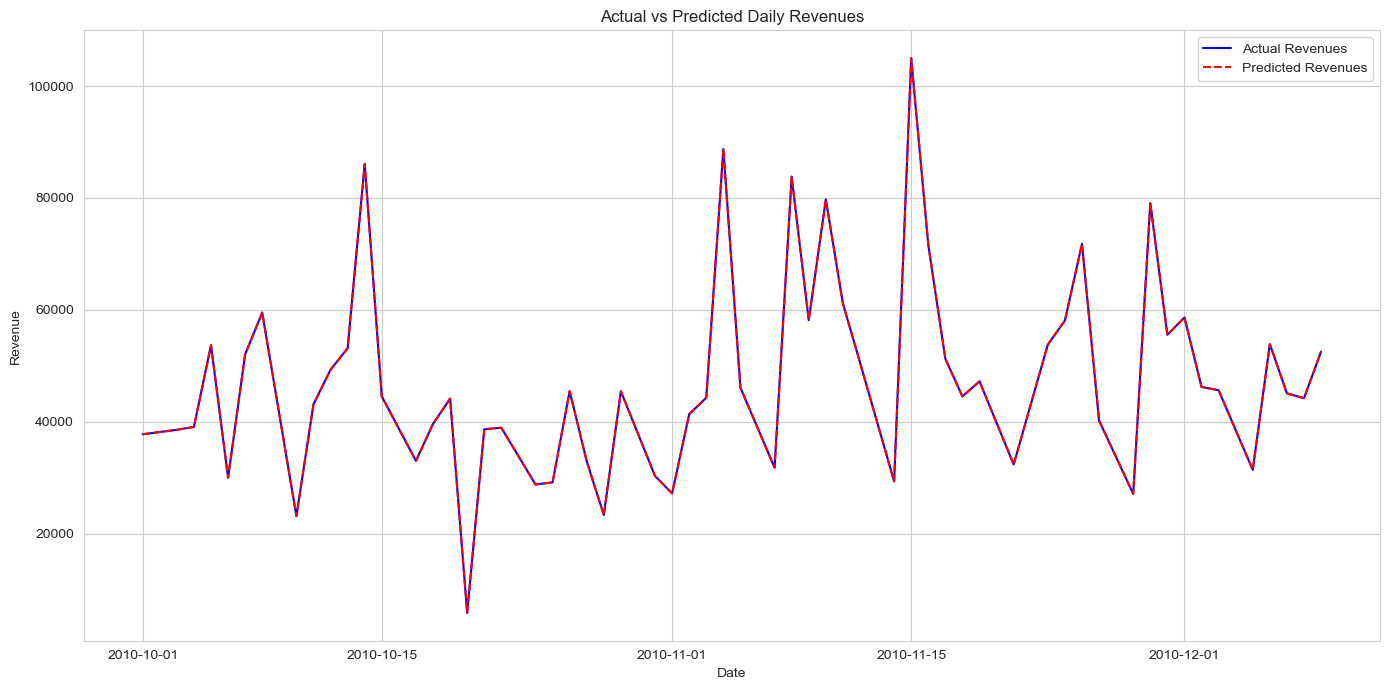

In [248]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(14, 7))

plt.plot(X_test.index, y_test, label="Actual Revenues", color="blue")
plt.plot(X_test.index, y_pred, label="Predicted Revenues", color="red", linestyle="--")

plt.title("Actual vs Predicted Daily Revenues")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model: Linear Regression
- The predicted revenues closely follow the actual revenues, which means that the model is able to accurately predict the future revenues.
- The fact that the model achieves a near-perfect fit is commendable, but it is important to be cautious of such models. This is because it is possible that the model has been overfit to the training data. Overfitting occurs when a model learns the details of the training data too well, and as a result, it is not able to generalize well to new data.
- It is essential to ensure that there is no data leakage. Data leakage occurs when the model is trained on data that it will also see in the test set. This can lead to the model overfitting to the training data and not generalizing well to new data.
- It is also essential to ensure that the model generalizes well to new, unseen data. This can be done by validating the model on a separate test set that was not used to train the model.

Let's check out other models and see what we find.

In [253]:
# Initializing the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
}

# Training the models, making predictions, and computing RMSE
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_model = model.predict(X_test)
    rmse_model = mean_squared_error(y_test, y_pred_model, squared=False)
    results[name] = rmse_model

results

{'Linear Regression': 8.416012716123292e-11,
 'Random Forest': 15099.41856790101,
 'Gradient Boosting': 15360.99743645723,
 'Ridge': 5.751595623150548e-06,
 'Lasso': 6.437858972509678,
 'ElasticNet': 6.4382820815101045}

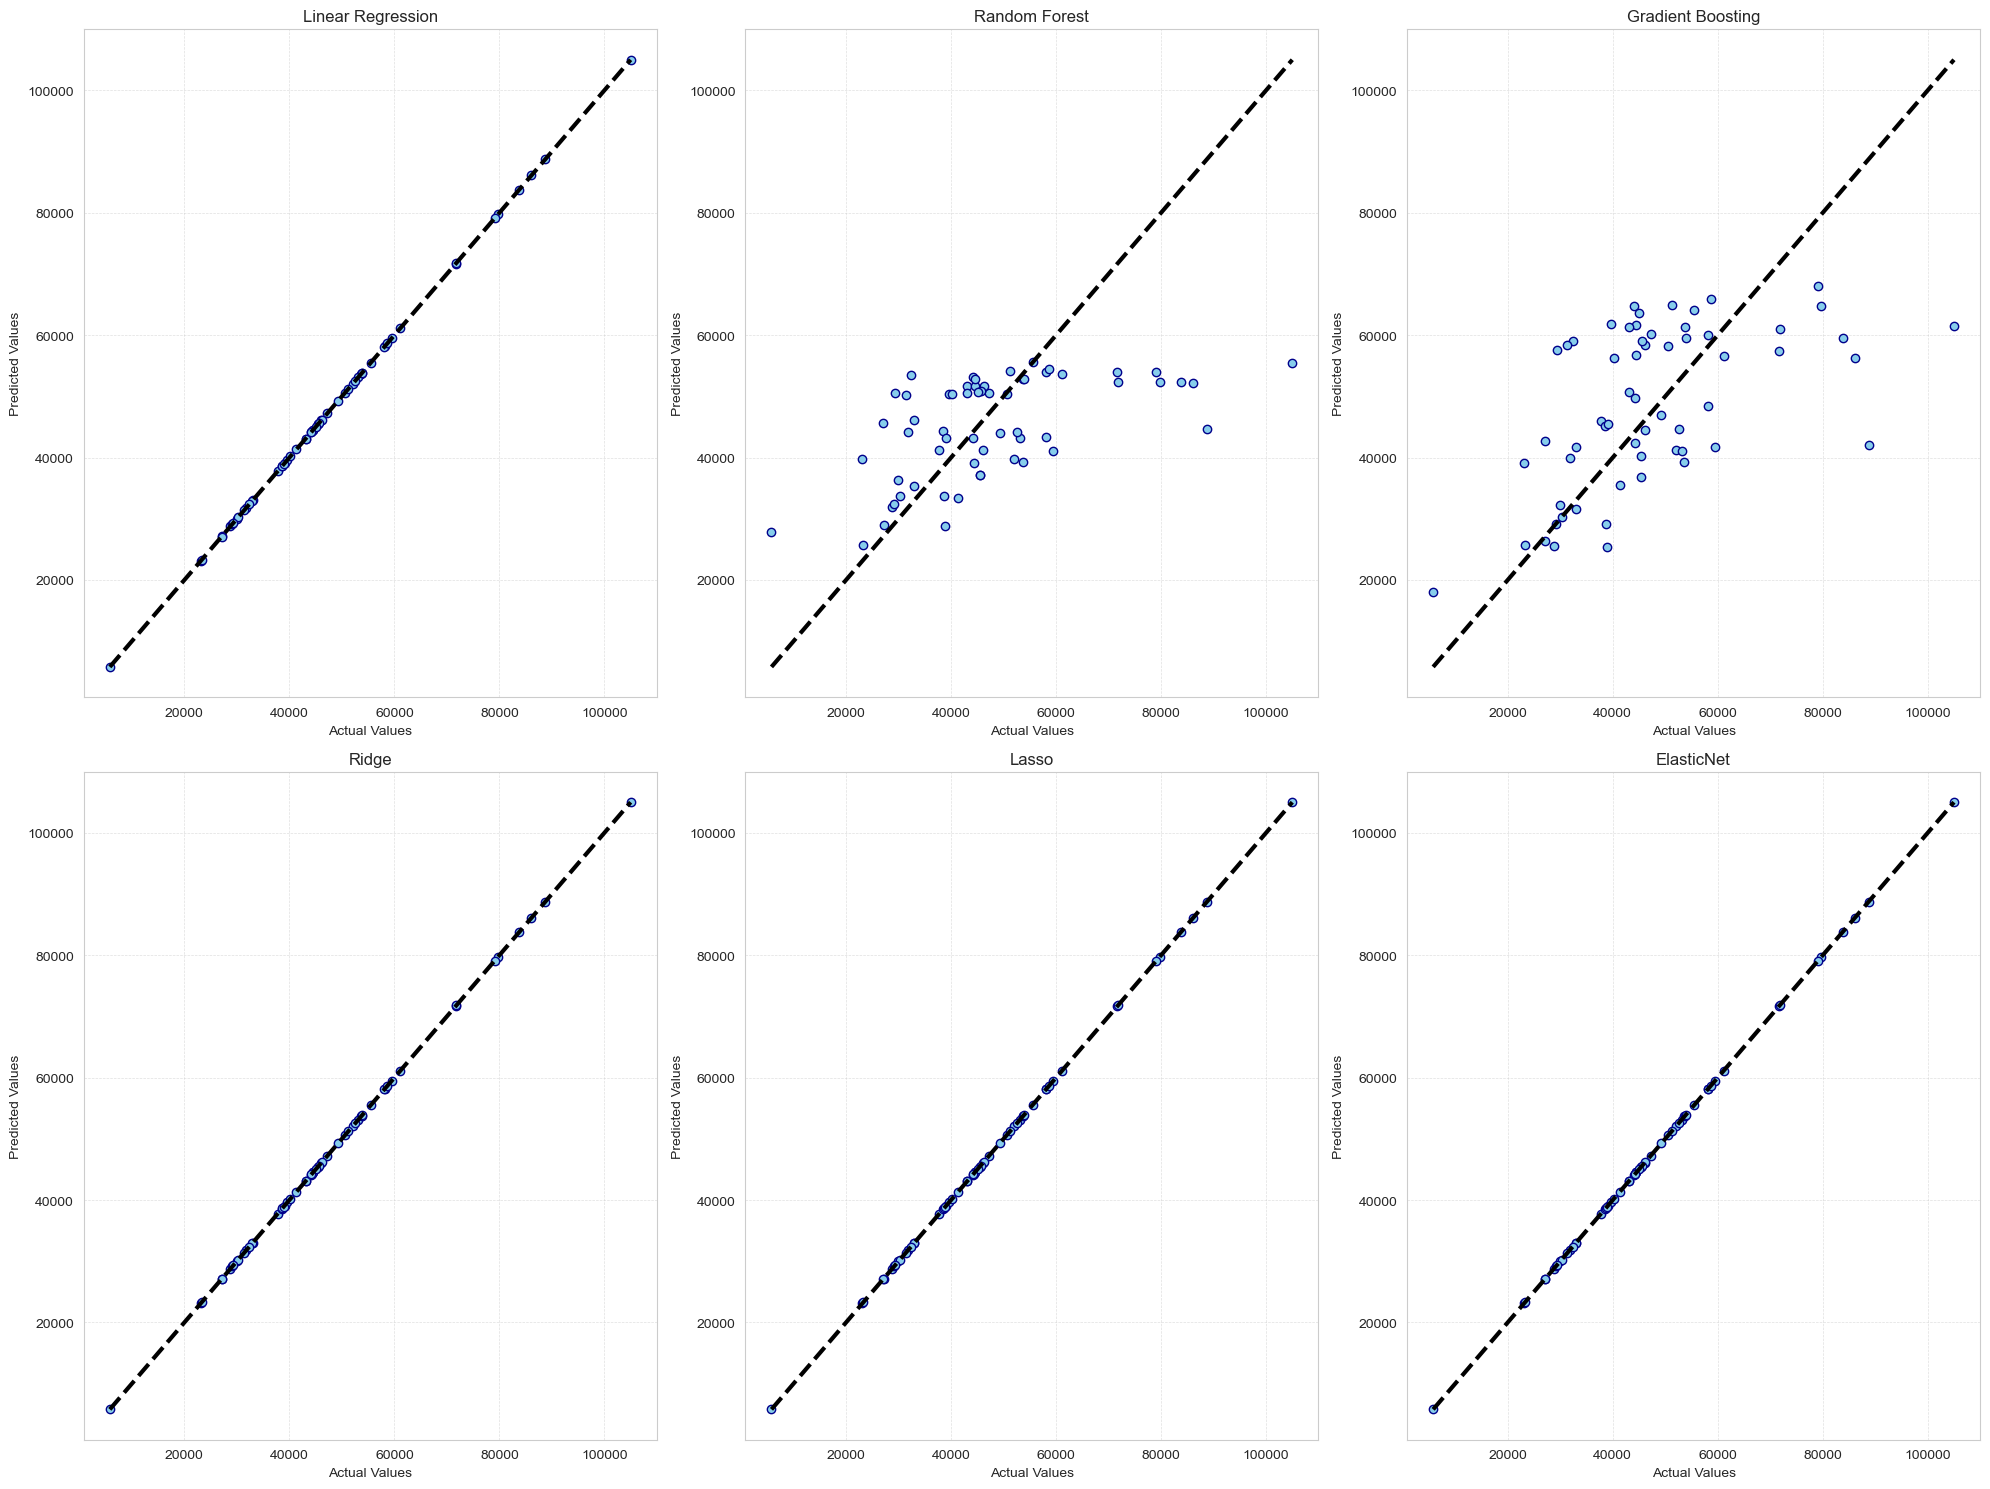

In [254]:
# Generating predictions for each model
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test)

# Creating scatter plots for each model's predictions vs. actual values
plt.figure(figsize=(20, 15))

for idx, (name, y_pred_model) in enumerate(predictions.items(), 1):
    plt.subplot(2, 3, idx)
    plt.scatter(y_test, y_pred_model, color="skyblue", edgecolor="darkblue")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=3)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(name)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

- Linear Regression: Extremely low RMSE, indicating near-perfect predictions.
- Random Forest and Gradient Boosting: Higher RMSE values, suggesting these models did not capture the underlying pattern as well as the Linear Regression model for this dataset.
- Ridge: Very low RMSE, though not as low as Linear Regression.
- Lasso and ElasticNet: Low RMSE values, but still higher than Linear Regression.

In [255]:
# Collecting performance metrics for each model
performance_data = {"Model": [], "RMSE": [], "MAE": [], "R²": []}

for name, model in models.items():
    y_pred_model = model.predict(X_test)
    rmse_model = mean_squared_error(y_test, y_pred_model, squared=False)
    mae_model = mean_absolute_error(y_test, y_pred_model)
    r2_model = r2_score(y_test, y_pred_model)

    performance_data["Model"].append(name)
    performance_data["RMSE"].append(rmse_model)
    performance_data["MAE"].append(mae_model)
    performance_data["R²"].append(r2_model)

performance_df = pd.DataFrame(performance_data)
performance_df

Model          RMSE           MAE        R²
0  Linear Regression  8.416013e-11  7.473015e-11  1.000000
1      Random Forest  1.509942e+04  1.108237e+04  0.286570
2  Gradient Boosting  1.536100e+04  1.207067e+04  0.261637
3              Ridge  5.751596e-06  4.266899e-06  1.000000
4              Lasso  6.437859e+00  5.018779e+00  1.000000
5         ElasticNet  6.438282e+00  5.019157e+00  1.000000

- Linear Regression delivers near-perfect performance with extremely low RMSE and MAE values, and an R^2 score of 1.
- Random Forest and Gradient Boosting show higher discrepancies in predictions, as reflected by their RMSE and MAE values.
- Ridge, Lasso, and ElasticNet exhibit good metrics, but not as precise as the Linear Regression model.

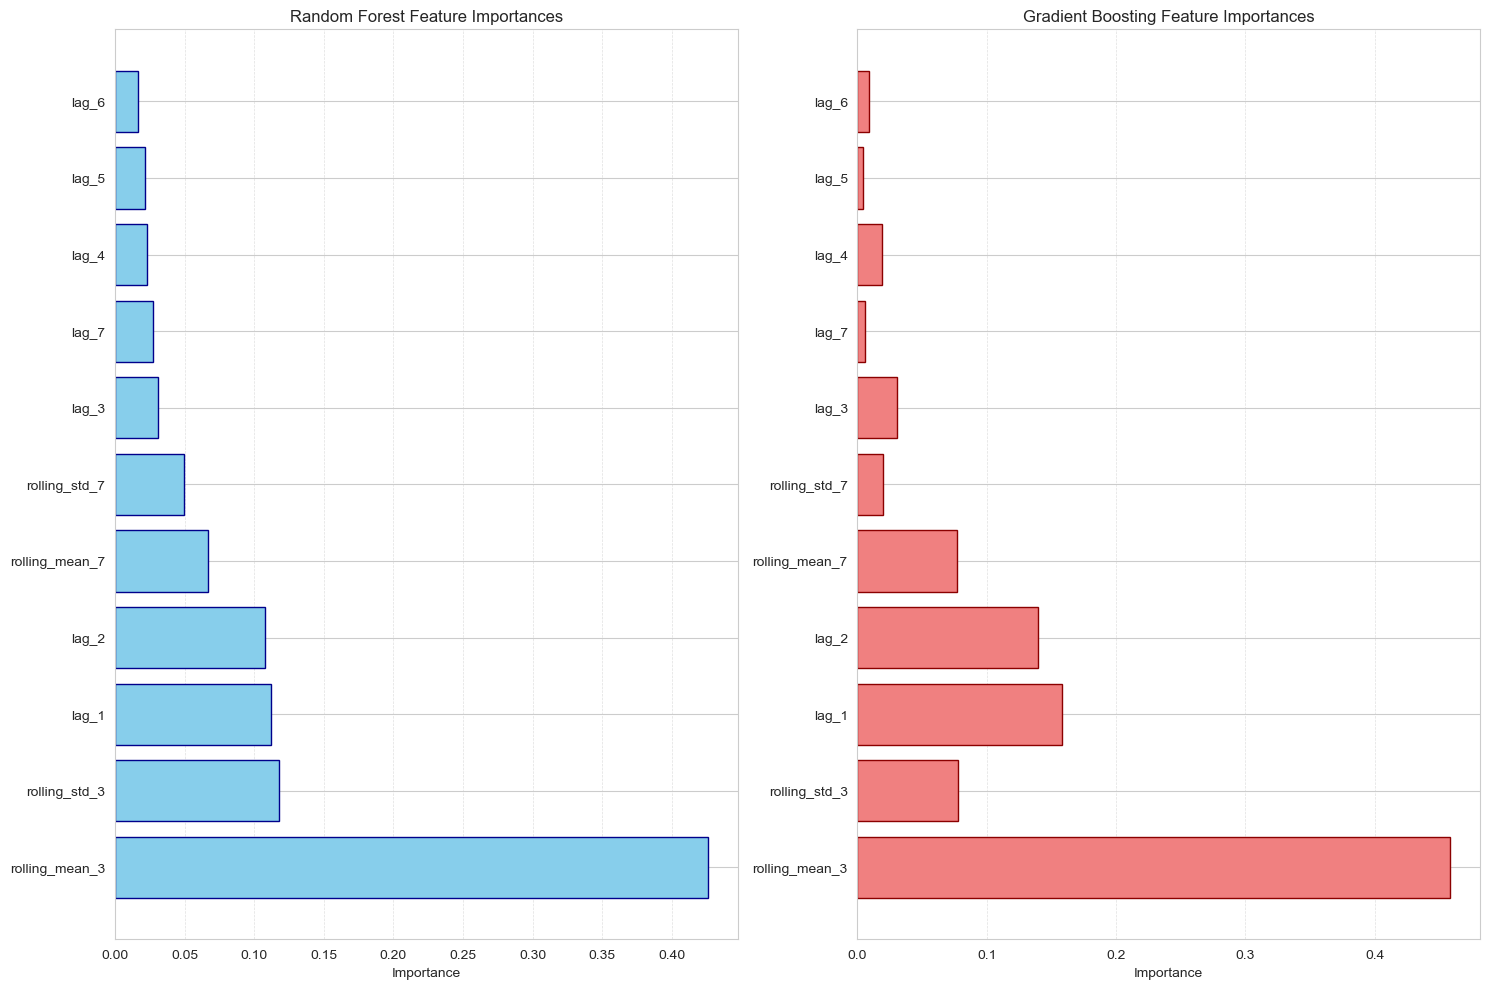

In [256]:
# Extracting feature importances for Random Forest and Gradient Boosting
feature_importance_data = {
    "Feature": X_train.columns,
    "Random Forest Importance": models["Random Forest"].feature_importances_,
    "Gradient Boosting Importance": models["Gradient Boosting"].feature_importances_,
}

feature_importance_df = pd.DataFrame(feature_importance_data)
feature_importance_df = feature_importance_df.sort_values(
    by="Random Forest Importance", ascending=False
)

# Plotting feature importances
plt.figure(figsize=(15, 10))

# Random Forest Feature Importances
plt.subplot(1, 2, 1)
plt.barh(
    feature_importance_df["Feature"],
    feature_importance_df["Random Forest Importance"],
    color="skyblue",
    edgecolor="darkblue",
)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

# Gradient Boosting Feature Importances
plt.subplot(1, 2, 2)
plt.barh(
    feature_importance_df["Feature"],
    feature_importance_df["Gradient Boosting Importance"],
    color="lightcoral",
    edgecolor="darkred",
)
plt.xlabel("Importance")
plt.title("Gradient Boosting Feature Importances")
plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

- The Random Forest and Gradient Boosting models both place high importance on the lag_1, rolling_mean_7, and rolling_std_7 features.
- These features are all related to recent past values, which suggests that they are important predictors for both models.
- The order of importance of the features is slightly different for the two models, but they both agree that these three features are the most important.

##### 5.2.1 Tuning The Hyperparameters For The Random Forest Model

In [258]:
# Hyperparameters grid for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# Random search of hyperparameters using 3 fold cross-validation
rf_random_search = RandomizedSearchCV(
    estimator=models["Random Forest"],
    param_distributions=rf_param_grid,
    n_iter=50,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search model
rf_random_search.fit(X_train, y_train)

# Best hyperparameters from random search
rf_best_params = rf_random_search.best_params_
rf_best_params

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None,
 'bootstrap': True}

- With these optimal hyperparameters, let's retrain the Random Forest model and evaluate its performance on the test set. We'll then compare the results with the previous Random Forest model to determine if there's an improvement in performance.

In [259]:
# Retraining the Random Forest model with best hyperparameters
rf_optimized = RandomForestRegressor(**rf_best_params, random_state=42)
rf_optimized.fit(X_train, y_train)

# Making predictions and evaluating performance
y_pred_rf_optimized = rf_optimized.predict(X_test)
rmse_rf_optimized = mean_squared_error(y_test, y_pred_rf_optimized, squared=False)
mae_rf_optimized = mean_absolute_error(y_test, y_pred_rf_optimized)
r2_rf_optimized = r2_score(y_test, y_pred_rf_optimized)

rmse_rf_optimized, mae_rf_optimized, r2_rf_optimized

(16260.023657741545, 11213.31995274429, 0.1726805672201941)

- The tuned Random Forest model has slightly worse performance than the original model.

##### 5.2.2 Tuning The Hyperparameters For The Gradient Boosting Model

In [261]:
# Hyperparameters grid for Gradient Boosting
gb_param_grid = {
    "n_estimators": [50, 100, 200, 500],
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1],
    "max_depth": [3, 5, 10, 20],
    "subsample": [0.5, 0.8, 1.0],
    "max_features": ["auto", "sqrt", "log2", None],
}

# Random search of hyperparameters using 3 fold cross-validation
gb_random_search = RandomizedSearchCV(
    estimator=models["Gradient Boosting"],
    param_distributions=gb_param_grid,
    n_iter=50,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search model
gb_random_search.fit(X_train, y_train)

# Best hyperparameters from random search
gb_best_params = gb_random_search.best_params_
gb_best_params

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'subsample': 0.8,
 'n_estimators': 500,
 'max_features': None,
 'max_depth': 10,
 'learning_rate': 0.01}

- With these optimal hyperparameters, let's retrain the Gradient Boosting model and evaluate its performance on the test set. We'll then compare the results with the previous Gradient Boosting model to determine if there's an improvement in performance.

In [262]:
# Retraining the Gradient Boosting model with best hyperparameters
gb_optimized = GradientBoostingRegressor(**gb_best_params, random_state=42)
gb_optimized.fit(X_train, y_train)

# Making predictions and evaluating performance
y_pred_gb_optimized = gb_optimized.predict(X_test)
rmse_gb_optimized = mean_squared_error(y_test, y_pred_gb_optimized, squared=False)
mae_gb_optimized = mean_absolute_error(y_test, y_pred_gb_optimized)
r2_gb_optimized = r2_score(y_test, y_pred_gb_optimized)

rmse_gb_optimized, mae_gb_optimized, r2_gb_optimized

(17726.882275677577, 14083.589384088968, 0.016678351958828275)

- Gradient Boosting model performed slightly better after hyperparameter tuning, but the improvement is not substantial.
- Linear Regression model is still the standout performer.

Overall Summary:

- Linear Regression: Produced almost perfect predictions with an R^2 value of 1 and extremely low RMSE and MAE values.
- Ridge, Lasso, and ElasticNet: Also produced nearly perfect predictions, with R^2 values of 1 and very low RMSE and MAE values.

### 5.3 Clustering

In [269]:
# Load the cleaned dataset
data_cleaned = pd.read_csv("cleaned.csv")
data_cleaned["InvoiceDate"] = pd.to_datetime(data_cleaned["InvoiceDate"])

# Define the point in time for computing recency
snapshot_date = data_cleaned["InvoiceDate"].max() + timedelta(days=1)

# Computing the Monetary value for each transaction
data_cleaned["MonetaryValue"] = data_cleaned["Quantity"] * data_cleaned["Price"]

# Compute RFM values
rfm_data = (
    data_cleaned.groupby("Customer ID")
    .agg(
        {
            "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
            "Invoice": "count",  # Frequency
            "MonetaryValue": "sum",  # Monetary Value
        }
    )
    .rename(
        columns={
            "InvoiceDate": "Recency",
            "Invoice": "Frequency",
            "MonetaryValue": "MonetaryValue",
        }
    )
)

# Scaling the RFM data
scaler = StandardScaler()
rfm_data_scaled = scaler.fit_transform(rfm_data)

# Return first few rows to verify
rfm_data.head()

Recency  Frequency  MonetaryValue
Customer ID                                   
-1                 1     104999     1191276.06
 12346            67         46         -64.68
 12347             3         71        1323.32
 12348            74         20         222.16
 12349            43        107        2646.99

In [270]:
rfm_data_scaled[:5]

array([[-9.20652405e-01,  6.56575406e+01,  5.98189678e+01],
       [-2.48305346e-01, -4.58194570e-02, -1.12718694e-01],
       [-9.00278252e-01, -3.01687943e-02, -4.28938509e-02],
       [-1.76995809e-01, -6.20961462e-02, -9.82888975e-02],
       [-4.92795186e-01, -7.63184003e-03,  2.36948024e-02]])

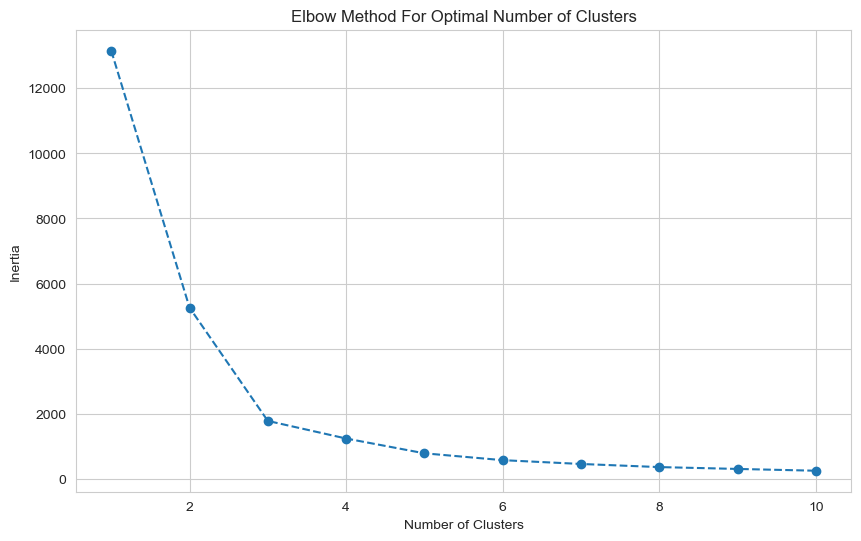

In [271]:
# Compute the sum of squared distances (inertia) for a range of number of cluster
inertia = []
range_clusters = range(1, 11)

for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rfm_data_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10,6))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [272]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(rfm_data_scaled)

# Assigning cluster labels to the original RFM data
rfm_data['Cluster'] = cluster_labels

# Computing cluster centroids
cluster_centroids = rfm_data.groupby('Cluster').mean()

cluster_centroids

Recency      Frequency  MonetaryValue
Cluster                                          
0         41.827149     116.602413   2.383178e+03
1          1.000000  104999.000000   1.191276e+06
2        245.250936      29.023408   4.194516e+02

- Cluster 0: These customers have made a purchase within the past 42 days, have made an average of 117 transactions, and have spent an average of £2,383.
- Cluster 1: These customers are outliers with very recent purchases (1 day ago), a very high frequency of transactions (104,999), and a significantly high monetary value of £1,191,276.
- Cluster 2: These customers are inactive with a purchase made 245 days ago, an average of 29 transactions, and an average spend of £419.

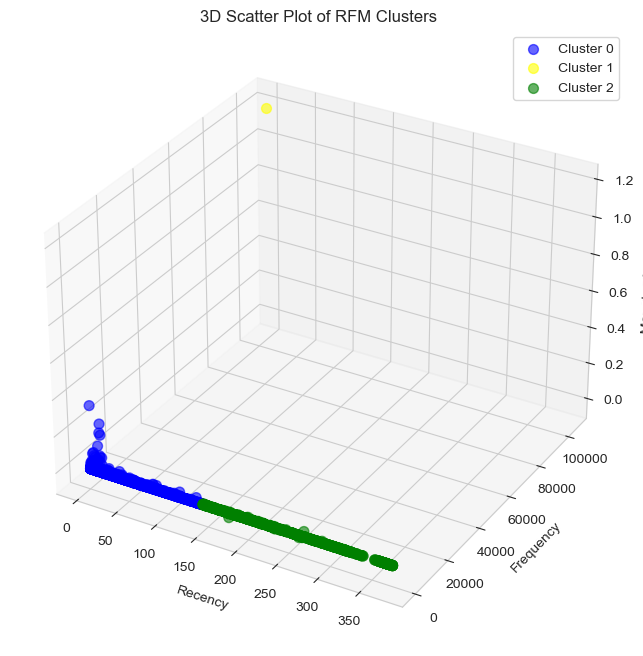

In [276]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot each cluster in a different color
colors = ["blue", "yellow", "green"]
for cluster, color in zip(range(3), colors):
    subset = rfm_data[rfm_data["Cluster"] == cluster]
    ax.scatter(
        subset["Recency"],
        subset["Frequency"],
        subset["MonetaryValue"],
        s=50,
        c=color,
        label=f"Cluster {cluster}",
        alpha=0.6,
    )

# Set plot title and axes labels
ax.set_title("3D Scatter Plot of RFM Clusters")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("MonetaryValue")
ax.legend()
ax.grid(True)

plt.show()

- Cluster 1 is the most valuable cluster and should be engaged with through re-engagement campaigns to understand their preferences or reasons for not shopping.
- Cluster 2 is at risk of churning and should be appreciated and rewarded for their loyalty. Consider strategies to further enhance their shopping experience.
- Cluster 0 is a more general group with a mix of characteristics. You can segment Cluster 0 further if needed, or tailor general marketing campaigns to cater to their diverse needs.

### Conclusion

This notebook presents a comprehensive analysis of an online retail dataset. The analysis started with data exploration and cleaning, then customer segmentation, time series decomposition, and cohort analysis. Advanced techniques, like clustering and time series forecasting, were used to understand customer behavior and sales trends holistically. The visualizations made complex data patterns easier to understand.

### Recommendations

- Focus on customer retention: The cohort analysis showed that repeat customers are more valuable than new customers. So, the company should focus on retention strategies, like loyalty programs or exclusive offers.
- Target "at-risk" customers: The segmentation analysis identified a segment of customers who are "at risk" of churning. The company can target these customers with specific marketing campaigns to prevent them from leaving.
- Plan seasonal campaigns: The time series decomposition revealed clear seasonal patterns in the sales data. The company can plan marketing campaigns around peak months to maximize revenue.
- Improve data quality: The initial data exploration revealed some inconsistencies and missing values. The company should implement stricter data validation at the point of entry to improve the overall quality of the dataset.